In [563]:
from datetime import datetime
import time
from collections import namedtuple
import seaborn as sns; 
sns.set(style="ticks", color_codes=True)
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import precision_recall_fscore_support
now = datetime.utcnow(). strftime("% Y% m% d% H% M% S")
root_logdir = "tf_logs"
logdir = "{}/ run-{}/". format( root_logdir, now)

###### IMPORTING THE FASHION TEST AND TRAINING DATA INTO DATASET

In [564]:
training_file = 'fashionmnist/fashion-mnist_train.csv'
test_file = 'fashionmnist/fashion-mnist_test.csv'
train_df = pd.read_csv(training_file)
test_df = pd.read_csv(test_file)
# train_df.head(10)
train_ds = train_df.values
test_ds = test_df.values
train_ds_X = train_ds[:,1:]
test_ds_X = test_ds[:,1:]
train_ds_Y = train_ds[:,:1]
test_ds_Y = test_ds[:,:1]
train_ds_X_rc = train_ds_X.reshape(-1,28,28)
test_ds_X_rc = test_ds_X.reshape(-1,28,28)
train_ds_X_shape = train_ds_X.reshape(-1,28,28,1)
test_ds_X_val = test_ds_X_rc.reshape(-1,28,28,1)

###### DISPLAY IT INTO IMAGES

In [565]:
%matplotlib inline

def show_image(search_index):
    #search_index = 12343
    label_classes = ['top','trouser','pullover','dress','coat','sandal','shirt','sneaker','bag','boot']
    from matplotlib import pyplot as plt
    print("IMAGE TYPE:", label_classes[train_ds_Y[search_index][0]])
    plt.imshow(train_ds_X_rc[search_index], interpolation='gaussian', cmap="gray")
    plt.show()

IMAGE TYPE: pullover


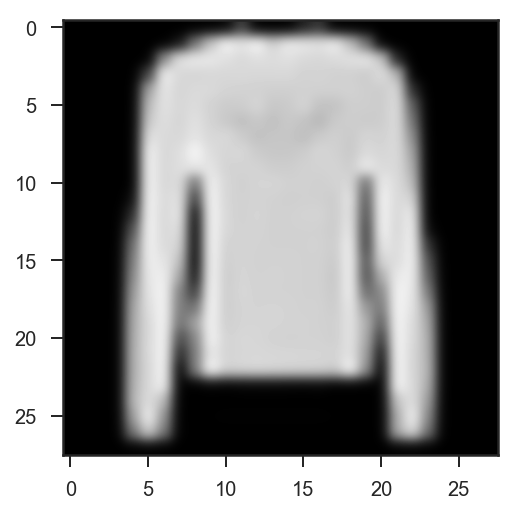

In [566]:
show_image(18333)

###### NORMALIZE AND ONE HOT CODE

In [567]:
def one_hot_encode(x, n_classes):
    return np.eye(n_classes)[x.reshape(-1)]

def normalize(train_ds_X):
    norm_func = lambda t: t / 256
    vfunc = np.vectorize(norm_func)
    return vfunc(train_ds_X)
train_ds_X_shape = normalize(train_ds_X_shape)
train_ds_Y = one_hot_encode(train_ds_Y,10)
test_ds_X_shape = normalize(test_ds_X_val)
test_ds_Y = one_hot_encode(test_ds_Y,10)

In [568]:

def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

def get_data_batches(batch_size = 128):
    X, Y = unison_shuffled_copies(train_ds_X_shape, train_ds_Y)
    number_batches = int(len(X)/batch_size)
    x_batches = np.array(np.array_split(X, number_batches))
    y_batches = np.array(np.array_split(Y, number_batches))
    return x_batches,y_batches

In [569]:
xx, yy = get_data_batches(64)
print(xx.shape)

(937,)


###### BUILD THE CNN MODEL

###### BASIC INPUTS

In [570]:
def neural_net_image_input(image_shape):
    return tf.placeholder(tf.float32, shape=(None,) + image_shape , name="x")


def neural_net_label_input(n_classes):
    return tf.placeholder(tf.float32, shape=(None,n_classes) , name="y")


def neural_net_keep_prob_input():
    return tf.placeholder(tf.float32, name="keep_prob")

###### CONV LAYER WITH MAX POOLING

In [571]:
def conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides):
    
    # Output depth
    k_output = conv_num_outputs
    
    input_shape = x_tensor.get_shape().as_list()

    # Image Properties
    image_width = input_shape[1]
    image_height = input_shape[2]
    color_channels = input_shape[3]

    # Convolution filter
    filter_size_width = conv_ksize[0]
    filter_size_height = conv_ksize[1]
    
    
    # Weight and bias
    weight = tf.Variable(tf.truncated_normal(
        [filter_size_height, filter_size_width, color_channels, k_output]))
    bias = tf.Variable(tf.zeros(k_output))
    
    #weight should be propotional to filter size
    conv_layer = tf.nn.conv2d(x_tensor, weight, strides=[1,conv_strides[0],conv_strides[1],1], padding='SAME')
    
    # Add bias
    conv_layer = tf.nn.bias_add(conv_layer, bias)
    
    # Apply activation function
    
    conv_layer = tf.nn.relu(conv_layer)
    
    #Adding max pooling layer to it
    
    return tf.nn.max_pool(
        conv_layer,
        ksize=[1, pool_ksize[0], pool_ksize[1], 1],
        strides=[1, pool_strides[0],pool_strides[1], 1],
        padding='SAME')

###### FLATTEN LAYER TO CONVERT 4D TO 2D (NUMBER BATCHES, FLATENNED DIMENSIONS)

In [572]:
def flatten(x_tensor):
    return tf.contrib.layers.flatten(x_tensor)

###### FULLY CONNECTED DENSE LAYER WITH RELU ACTIVATION

In [573]:
def fully_conn(x_tensor, num_outputs):
    return tf.contrib.layers.fully_connected(x_tensor, num_outputs)


###### OUTPUT A SIMPLE DENSE LAYER

In [574]:
def output(x_tensor, num_outputs):
    return tf.layers.dense(inputs=x_tensor, units=num_outputs)

###### BUILDING THE CONV NET

In [575]:
def conv_net(x, keep_prob):
    # Currently we have two Fully Connected and one conv,(TODO: Try atleast 2 conv layers)
    # Function Definition from Above:
    #    conv2d_maxpool(x_tensor, conv_num_outputs, conv_ksize, conv_strides, pool_ksize, pool_strides)
        
    #Parameters input, conv net dimensions, filter sizes, stride dimensions, pool size, pool stride
    conv_output = conv2d_maxpool(x, 10, (4,4), (2,2), (2,2), (2,2))
    
    conv_output = conv2d_maxpool(conv_output, 30, (2,2), (1,1), (1,1), (1,1))

    # Apply a Flatten Layer
    # Function Definition from Above:
    flattened_output = flatten(conv_output)
    
    # Apply 1, 2, or 3 Fully Connected Layers
    #    Play around with different number of outputs
    # Function Definition from Above:
    fully_con_output = fully_conn(flattened_output, 256)
    # Adding a drop out layer
    fully_con_output = tf.nn.dropout(fully_con_output, keep_prob)
    # Adding another layer
    
    fully_con_output = fully_conn(fully_con_output, 64)
    # Adding a drop out layer
    fully_con_output = tf.nn.dropout(fully_con_output, keep_prob)
    
    fully_con_output = fully_conn(fully_con_output, 32)
      
    #Apply an Output Layer
    #    Set this to the number of classes
    # Function Definition from Above:
    final_output = output(fully_con_output, 10)
    
    return final_output

In [576]:
# Remove previous weights, bias, inputs, etc..
tf.reset_default_graph()

# Inputs
x = neural_net_image_input((28, 28, 1))
y = neural_net_label_input(10)
keep_prob = neural_net_keep_prob_input()

# Model
logits = conv_net(x, keep_prob)
# Save logits with a particular name to use later
logits = tf.identity(logits, name='logits')

# Loss and Optimizer
learning_rate=0.01
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Accuracy
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32), name='accuracy')

###### FUNCTION TO PRINT STATS

In [577]:
def print_stats(session, feature_batch, label_batch, cost, accuracy):
    # Calculate batch loss and accuracy
    loss = session.run(cost, feed_dict={
        x: feature_batch,
        y: label_batch,
        keep_prob: 1.})
    valid_acc = sess.run(accuracy, feed_dict={
        x: test_ds_X_shape,
        y: test_ds_Y,
        keep_prob: 1.})
    print("Loss in this Epoch is:",loss * 100,"%")
    print("Accuracy in this Epoch is:",valid_acc * 100, "%")

###### RUN NEURAL NETWORK

In [578]:
def train_neural_network(session, optimizer, keep_probability, feature_batch, label_batch):
    session.run(optimizer, feed_dict={
        x: feature_batch,
        y: label_batch,
    keep_prob: keep_probability})

###### HYPER PARAMETERS

In [579]:
#  Tune Parameters
epochs = 100
batch_size = 256
keep_probability = 1.0

###### TRAIN THE MODEL

In [580]:
print('Checking the Training on a Single Batch...')
with tf.Session() as sess:
    # Initializing the variables
    sess.run(tf.global_variables_initializer())
    x_batches, y_batches = get_data_batches(batch_size)
    train_neural_network(sess, optimizer, keep_probability, x_batches[0], y_batches[0])
    print_stats(sess, x_batches[0], y_batches[0], cost, accuracy)
    # Training cycle
    for epoch in range(epochs):
        batch_features, batch_labels = get_data_batches(batch_size)
        for batch_num in range(len(batch_features)):
            train_neural_network(sess, optimizer, keep_probability, batch_features[batch_num], batch_labels[batch_num])
            loss = sess.run(cost, feed_dict={
                x: batch_features[batch_num],
                y: batch_labels[batch_num],
                keep_prob: 1.})
            print('Epoch {:>2}, Batch {} Loss:{}'.format(epoch + 1, batch_num, loss))
        print_stats(sess, batch_features[-1], batch_labels[-1], cost, accuracy)
        

Checking the Training on a Single Batch...
Loss in this Epoch is: 1160.06383896 %
Accuracy in this Epoch is: 10.000000149 %
Epoch  1, Batch 0 Loss:9.740909576416016
Epoch  1, Batch 1 Loss:11.004676818847656
Epoch  1, Batch 2 Loss:8.21949577331543
Epoch  1, Batch 3 Loss:7.067757606506348
Epoch  1, Batch 4 Loss:6.615631580352783
Epoch  1, Batch 5 Loss:3.918010950088501
Epoch  1, Batch 6 Loss:2.516124963760376
Epoch  1, Batch 7 Loss:2.4978766441345215
Epoch  1, Batch 8 Loss:3.098522901535034
Epoch  1, Batch 9 Loss:2.7534830570220947
Epoch  1, Batch 10 Loss:2.250993490219116
Epoch  1, Batch 11 Loss:2.136115550994873
Epoch  1, Batch 12 Loss:2.1812171936035156
Epoch  1, Batch 13 Loss:1.9972983598709106
Epoch  1, Batch 14 Loss:1.8469089269638062
Epoch  1, Batch 15 Loss:1.8317807912826538
Epoch  1, Batch 16 Loss:1.897744059562683
Epoch  1, Batch 17 Loss:1.9299979209899902
Epoch  1, Batch 18 Loss:1.864304542541504
Epoch  1, Batch 19 Loss:1.8448574542999268
Epoch  1, Batch 20 Loss:1.782776355743

Epoch  1, Batch 189 Loss:0.4769638776779175
Epoch  1, Batch 190 Loss:0.4143062233924866
Epoch  1, Batch 191 Loss:0.37721341848373413
Epoch  1, Batch 192 Loss:0.4711039960384369
Epoch  1, Batch 193 Loss:0.3885910212993622
Epoch  1, Batch 194 Loss:0.46453413367271423
Epoch  1, Batch 195 Loss:0.5508047938346863
Epoch  1, Batch 196 Loss:0.4441644549369812
Epoch  1, Batch 197 Loss:0.5147930383682251
Epoch  1, Batch 198 Loss:0.4892686605453491
Epoch  1, Batch 199 Loss:0.3703519105911255
Epoch  1, Batch 200 Loss:0.42388927936553955
Epoch  1, Batch 201 Loss:0.3553289473056793
Epoch  1, Batch 202 Loss:0.4556238651275635
Epoch  1, Batch 203 Loss:0.3917774260044098
Epoch  1, Batch 204 Loss:0.42340338230133057
Epoch  1, Batch 205 Loss:0.4777824282646179
Epoch  1, Batch 206 Loss:0.45123785734176636
Epoch  1, Batch 207 Loss:0.4164358377456665
Epoch  1, Batch 208 Loss:0.4627704918384552
Epoch  1, Batch 209 Loss:0.431082546710968
Epoch  1, Batch 210 Loss:0.4809848368167877
Epoch  1, Batch 211 Loss:0.3

Epoch  2, Batch 147 Loss:0.31553906202316284
Epoch  2, Batch 148 Loss:0.38409334421157837
Epoch  2, Batch 149 Loss:0.3395557999610901
Epoch  2, Batch 150 Loss:0.42775681614875793
Epoch  2, Batch 151 Loss:0.4644981026649475
Epoch  2, Batch 152 Loss:0.3174310028553009
Epoch  2, Batch 153 Loss:0.36940962076187134
Epoch  2, Batch 154 Loss:0.3153638243675232
Epoch  2, Batch 155 Loss:0.2783392071723938
Epoch  2, Batch 156 Loss:0.3094555139541626
Epoch  2, Batch 157 Loss:0.2780824303627014
Epoch  2, Batch 158 Loss:0.3642043471336365
Epoch  2, Batch 159 Loss:0.28169822692871094
Epoch  2, Batch 160 Loss:0.33371222019195557
Epoch  2, Batch 161 Loss:0.3731667399406433
Epoch  2, Batch 162 Loss:0.3371858298778534
Epoch  2, Batch 163 Loss:0.39834463596343994
Epoch  2, Batch 164 Loss:0.3111205995082855
Epoch  2, Batch 165 Loss:0.28583866357803345
Epoch  2, Batch 166 Loss:0.35390567779541016
Epoch  2, Batch 167 Loss:0.3338068127632141
Epoch  2, Batch 168 Loss:0.3539015054702759
Epoch  2, Batch 169 Los

Epoch  3, Batch 102 Loss:0.39604949951171875
Epoch  3, Batch 103 Loss:0.2794501781463623
Epoch  3, Batch 104 Loss:0.36389121413230896
Epoch  3, Batch 105 Loss:0.30352750420570374
Epoch  3, Batch 106 Loss:0.35223469138145447
Epoch  3, Batch 107 Loss:0.3499516248703003
Epoch  3, Batch 108 Loss:0.32226768136024475
Epoch  3, Batch 109 Loss:0.31658050417900085
Epoch  3, Batch 110 Loss:0.27250492572784424
Epoch  3, Batch 111 Loss:0.28725188970565796
Epoch  3, Batch 112 Loss:0.3077239394187927
Epoch  3, Batch 113 Loss:0.351543128490448
Epoch  3, Batch 114 Loss:0.23987364768981934
Epoch  3, Batch 115 Loss:0.33653318881988525
Epoch  3, Batch 116 Loss:0.2783140242099762
Epoch  3, Batch 117 Loss:0.2909590005874634
Epoch  3, Batch 118 Loss:0.3024596869945526
Epoch  3, Batch 119 Loss:0.38287365436553955
Epoch  3, Batch 120 Loss:0.32762449979782104
Epoch  3, Batch 121 Loss:0.30890679359436035
Epoch  3, Batch 122 Loss:0.2886033356189728
Epoch  3, Batch 123 Loss:0.3300083875656128
Epoch  3, Batch 124 

Epoch  4, Batch 57 Loss:0.21112766861915588
Epoch  4, Batch 58 Loss:0.2598140835762024
Epoch  4, Batch 59 Loss:0.3956831693649292
Epoch  4, Batch 60 Loss:0.3312511146068573
Epoch  4, Batch 61 Loss:0.2799379527568817
Epoch  4, Batch 62 Loss:0.282980352640152
Epoch  4, Batch 63 Loss:0.35253477096557617
Epoch  4, Batch 64 Loss:0.30202215909957886
Epoch  4, Batch 65 Loss:0.28843602538108826
Epoch  4, Batch 66 Loss:0.3070085942745209
Epoch  4, Batch 67 Loss:0.2555856704711914
Epoch  4, Batch 68 Loss:0.3013648986816406
Epoch  4, Batch 69 Loss:0.2763255834579468
Epoch  4, Batch 70 Loss:0.29839324951171875
Epoch  4, Batch 71 Loss:0.24612261354923248
Epoch  4, Batch 72 Loss:0.2725881040096283
Epoch  4, Batch 73 Loss:0.2625110447406769
Epoch  4, Batch 74 Loss:0.23415954411029816
Epoch  4, Batch 75 Loss:0.22527390718460083
Epoch  4, Batch 76 Loss:0.2803375720977783
Epoch  4, Batch 77 Loss:0.2572636008262634
Epoch  4, Batch 78 Loss:0.2460034191608429
Epoch  4, Batch 79 Loss:0.22733919322490692
Epo

Epoch  5, Batch 7 Loss:0.26088646054267883
Epoch  5, Batch 8 Loss:0.21237458288669586
Epoch  5, Batch 9 Loss:0.33333706855773926
Epoch  5, Batch 10 Loss:0.19963131844997406
Epoch  5, Batch 11 Loss:0.28195711970329285
Epoch  5, Batch 12 Loss:0.24794292449951172
Epoch  5, Batch 13 Loss:0.3021973967552185
Epoch  5, Batch 14 Loss:0.25767800211906433
Epoch  5, Batch 15 Loss:0.27561238408088684
Epoch  5, Batch 16 Loss:0.2094351202249527
Epoch  5, Batch 17 Loss:0.24005728960037231
Epoch  5, Batch 18 Loss:0.2894202470779419
Epoch  5, Batch 19 Loss:0.26934564113616943
Epoch  5, Batch 20 Loss:0.22815249860286713
Epoch  5, Batch 21 Loss:0.23810996115207672
Epoch  5, Batch 22 Loss:0.2182598114013672
Epoch  5, Batch 23 Loss:0.24605326354503632
Epoch  5, Batch 24 Loss:0.17593280971050262
Epoch  5, Batch 25 Loss:0.21679802238941193
Epoch  5, Batch 26 Loss:0.2362903207540512
Epoch  5, Batch 27 Loss:0.23974157869815826
Epoch  5, Batch 28 Loss:0.1827058047056198
Epoch  5, Batch 29 Loss:0.218248382210731

Epoch  5, Batch 195 Loss:0.22036217153072357
Epoch  5, Batch 196 Loss:0.27242231369018555
Epoch  5, Batch 197 Loss:0.21913591027259827
Epoch  5, Batch 198 Loss:0.18792496621608734
Epoch  5, Batch 199 Loss:0.2067531943321228
Epoch  5, Batch 200 Loss:0.2514772415161133
Epoch  5, Batch 201 Loss:0.2477944791316986
Epoch  5, Batch 202 Loss:0.24471203982830048
Epoch  5, Batch 203 Loss:0.213494673371315
Epoch  5, Batch 204 Loss:0.26360008120536804
Epoch  5, Batch 205 Loss:0.2318938970565796
Epoch  5, Batch 206 Loss:0.24741217494010925
Epoch  5, Batch 207 Loss:0.2846065163612366
Epoch  5, Batch 208 Loss:0.2560999393463135
Epoch  5, Batch 209 Loss:0.2181226909160614
Epoch  5, Batch 210 Loss:0.18315206468105316
Epoch  5, Batch 211 Loss:0.24750731885433197
Epoch  5, Batch 212 Loss:0.2979721426963806
Epoch  5, Batch 213 Loss:0.31104183197021484
Epoch  5, Batch 214 Loss:0.17940500378608704
Epoch  5, Batch 215 Loss:0.33317819237709045
Epoch  5, Batch 216 Loss:0.22644658386707306
Epoch  5, Batch 217 

Epoch  6, Batch 147 Loss:0.19902291893959045
Epoch  6, Batch 148 Loss:0.20130732655525208
Epoch  6, Batch 149 Loss:0.22571440041065216
Epoch  6, Batch 150 Loss:0.22778385877609253
Epoch  6, Batch 151 Loss:0.24269527196884155
Epoch  6, Batch 152 Loss:0.2017025351524353
Epoch  6, Batch 153 Loss:0.21926411986351013
Epoch  6, Batch 154 Loss:0.1914757639169693
Epoch  6, Batch 155 Loss:0.3217325806617737
Epoch  6, Batch 156 Loss:0.19214048981666565
Epoch  6, Batch 157 Loss:0.2176269292831421
Epoch  6, Batch 158 Loss:0.14224329590797424
Epoch  6, Batch 159 Loss:0.19289939105510712
Epoch  6, Batch 160 Loss:0.15059927105903625
Epoch  6, Batch 161 Loss:0.18555381894111633
Epoch  6, Batch 162 Loss:0.2620266377925873
Epoch  6, Batch 163 Loss:0.2527405023574829
Epoch  6, Batch 164 Loss:0.3073909878730774
Epoch  6, Batch 165 Loss:0.19841691851615906
Epoch  6, Batch 166 Loss:0.17786026000976562
Epoch  6, Batch 167 Loss:0.21611902117729187
Epoch  6, Batch 168 Loss:0.28038859367370605
Epoch  6, Batch 1

Epoch  7, Batch 99 Loss:0.21558551490306854
Epoch  7, Batch 100 Loss:0.20985732972621918
Epoch  7, Batch 101 Loss:0.2576324939727783
Epoch  7, Batch 102 Loss:0.16629323363304138
Epoch  7, Batch 103 Loss:0.25307220220565796
Epoch  7, Batch 104 Loss:0.22516997158527374
Epoch  7, Batch 105 Loss:0.1939609944820404
Epoch  7, Batch 106 Loss:0.15686452388763428
Epoch  7, Batch 107 Loss:0.2038012146949768
Epoch  7, Batch 108 Loss:0.23967687785625458
Epoch  7, Batch 109 Loss:0.2490016520023346
Epoch  7, Batch 110 Loss:0.17495808005332947
Epoch  7, Batch 111 Loss:0.18406541645526886
Epoch  7, Batch 112 Loss:0.1673567146062851
Epoch  7, Batch 113 Loss:0.1697365641593933
Epoch  7, Batch 114 Loss:0.1906311810016632
Epoch  7, Batch 115 Loss:0.16864249110221863
Epoch  7, Batch 116 Loss:0.23389190435409546
Epoch  7, Batch 117 Loss:0.2091519832611084
Epoch  7, Batch 118 Loss:0.2385861873626709
Epoch  7, Batch 119 Loss:0.2959563136100769
Epoch  7, Batch 120 Loss:0.20015034079551697
Epoch  7, Batch 121 L

Epoch  8, Batch 50 Loss:0.1715089976787567
Epoch  8, Batch 51 Loss:0.1870259940624237
Epoch  8, Batch 52 Loss:0.21140208840370178
Epoch  8, Batch 53 Loss:0.16572214663028717
Epoch  8, Batch 54 Loss:0.1767403781414032
Epoch  8, Batch 55 Loss:0.2414216697216034
Epoch  8, Batch 56 Loss:0.24119938910007477
Epoch  8, Batch 57 Loss:0.19423119723796844
Epoch  8, Batch 58 Loss:0.1603667140007019
Epoch  8, Batch 59 Loss:0.20279718935489655
Epoch  8, Batch 60 Loss:0.22505289316177368
Epoch  8, Batch 61 Loss:0.17729200422763824
Epoch  8, Batch 62 Loss:0.18180575966835022
Epoch  8, Batch 63 Loss:0.2603002190589905
Epoch  8, Batch 64 Loss:0.27935224771499634
Epoch  8, Batch 65 Loss:0.25377583503723145
Epoch  8, Batch 66 Loss:0.18219266831874847
Epoch  8, Batch 67 Loss:0.17309340834617615
Epoch  8, Batch 68 Loss:0.15724590420722961
Epoch  8, Batch 69 Loss:0.1823156476020813
Epoch  8, Batch 70 Loss:0.179002046585083
Epoch  8, Batch 71 Loss:0.1717132329940796
Epoch  8, Batch 72 Loss:0.2309774458408355

Epoch  9, Batch 0 Loss:0.13394048810005188
Epoch  9, Batch 1 Loss:0.1898641586303711
Epoch  9, Batch 2 Loss:0.24018971621990204
Epoch  9, Batch 3 Loss:0.16206148266792297
Epoch  9, Batch 4 Loss:0.18024088442325592
Epoch  9, Batch 5 Loss:0.15518058836460114
Epoch  9, Batch 6 Loss:0.16548728942871094
Epoch  9, Batch 7 Loss:0.18375040590763092
Epoch  9, Batch 8 Loss:0.22223950922489166
Epoch  9, Batch 9 Loss:0.18741267919540405
Epoch  9, Batch 10 Loss:0.1897694319486618
Epoch  9, Batch 11 Loss:0.16445592045783997
Epoch  9, Batch 12 Loss:0.1516413539648056
Epoch  9, Batch 13 Loss:0.11480652540922165
Epoch  9, Batch 14 Loss:0.14037226140499115
Epoch  9, Batch 15 Loss:0.18836134672164917
Epoch  9, Batch 16 Loss:0.16063399612903595
Epoch  9, Batch 17 Loss:0.16260109841823578
Epoch  9, Batch 18 Loss:0.20073486864566803
Epoch  9, Batch 19 Loss:0.15908151865005493
Epoch  9, Batch 20 Loss:0.20622800290584564
Epoch  9, Batch 21 Loss:0.14214274287223816
Epoch  9, Batch 22 Loss:0.2635470926761627
Ep

Epoch  9, Batch 190 Loss:0.16907495260238647
Epoch  9, Batch 191 Loss:0.22780856490135193
Epoch  9, Batch 192 Loss:0.1731712818145752
Epoch  9, Batch 193 Loss:0.15512628853321075
Epoch  9, Batch 194 Loss:0.1532515287399292
Epoch  9, Batch 195 Loss:0.18472544848918915
Epoch  9, Batch 196 Loss:0.26383015513420105
Epoch  9, Batch 197 Loss:0.16388370096683502
Epoch  9, Batch 198 Loss:0.1995052993297577
Epoch  9, Batch 199 Loss:0.19012492895126343
Epoch  9, Batch 200 Loss:0.17304019629955292
Epoch  9, Batch 201 Loss:0.20432308316230774
Epoch  9, Batch 202 Loss:0.2043580710887909
Epoch  9, Batch 203 Loss:0.14530140161514282
Epoch  9, Batch 204 Loss:0.2222045361995697
Epoch  9, Batch 205 Loss:0.2411046028137207
Epoch  9, Batch 206 Loss:0.17438599467277527
Epoch  9, Batch 207 Loss:0.23940816521644592
Epoch  9, Batch 208 Loss:0.24313382804393768
Epoch  9, Batch 209 Loss:0.17633819580078125
Epoch  9, Batch 210 Loss:0.1863245964050293
Epoch  9, Batch 211 Loss:0.20894755423069
Epoch  9, Batch 212 

Epoch 10, Batch 141 Loss:0.13772764801979065
Epoch 10, Batch 142 Loss:0.1319008618593216
Epoch 10, Batch 143 Loss:0.18785546720027924
Epoch 10, Batch 144 Loss:0.216242253780365
Epoch 10, Batch 145 Loss:0.13954372704029083
Epoch 10, Batch 146 Loss:0.16043275594711304
Epoch 10, Batch 147 Loss:0.14747405052185059
Epoch 10, Batch 148 Loss:0.15681752562522888
Epoch 10, Batch 149 Loss:0.2002537101507187
Epoch 10, Batch 150 Loss:0.17303985357284546
Epoch 10, Batch 151 Loss:0.2008465826511383
Epoch 10, Batch 152 Loss:0.12242749333381653
Epoch 10, Batch 153 Loss:0.18406441807746887
Epoch 10, Batch 154 Loss:0.13283251225948334
Epoch 10, Batch 155 Loss:0.15808264911174774
Epoch 10, Batch 156 Loss:0.15834087133407593
Epoch 10, Batch 157 Loss:0.23489224910736084
Epoch 10, Batch 158 Loss:0.14081260561943054
Epoch 10, Batch 159 Loss:0.20294862985610962
Epoch 10, Batch 160 Loss:0.2183920443058014
Epoch 10, Batch 161 Loss:0.14384515583515167
Epoch 10, Batch 162 Loss:0.17634353041648865
Epoch 10, Batch 

Epoch 11, Batch 91 Loss:0.16575488448143005
Epoch 11, Batch 92 Loss:0.16950766742229462
Epoch 11, Batch 93 Loss:0.1965802013874054
Epoch 11, Batch 94 Loss:0.20035675168037415
Epoch 11, Batch 95 Loss:0.1905566155910492
Epoch 11, Batch 96 Loss:0.14017435908317566
Epoch 11, Batch 97 Loss:0.14395186305046082
Epoch 11, Batch 98 Loss:0.18953490257263184
Epoch 11, Batch 99 Loss:0.1968347132205963
Epoch 11, Batch 100 Loss:0.14596101641654968
Epoch 11, Batch 101 Loss:0.1878143846988678
Epoch 11, Batch 102 Loss:0.1606786549091339
Epoch 11, Batch 103 Loss:0.16418185830116272
Epoch 11, Batch 104 Loss:0.16304132342338562
Epoch 11, Batch 105 Loss:0.15727418661117554
Epoch 11, Batch 106 Loss:0.1579308956861496
Epoch 11, Batch 107 Loss:0.10055795311927795
Epoch 11, Batch 108 Loss:0.12483467161655426
Epoch 11, Batch 109 Loss:0.1434042751789093
Epoch 11, Batch 110 Loss:0.1776849627494812
Epoch 11, Batch 111 Loss:0.1426941454410553
Epoch 11, Batch 112 Loss:0.1727675497531891
Epoch 11, Batch 113 Loss:0.14

Epoch 12, Batch 44 Loss:0.1573905497789383
Epoch 12, Batch 45 Loss:0.1452730894088745
Epoch 12, Batch 46 Loss:0.18783894181251526
Epoch 12, Batch 47 Loss:0.09524306654930115
Epoch 12, Batch 48 Loss:0.13023269176483154
Epoch 12, Batch 49 Loss:0.10746461898088455
Epoch 12, Batch 50 Loss:0.13371184468269348
Epoch 12, Batch 51 Loss:0.1085304245352745
Epoch 12, Batch 52 Loss:0.1109519973397255
Epoch 12, Batch 53 Loss:0.15149685740470886
Epoch 12, Batch 54 Loss:0.13768668472766876
Epoch 12, Batch 55 Loss:0.10469971597194672
Epoch 12, Batch 56 Loss:0.1384708434343338
Epoch 12, Batch 57 Loss:0.11710857599973679
Epoch 12, Batch 58 Loss:0.1543508917093277
Epoch 12, Batch 59 Loss:0.12886781990528107
Epoch 12, Batch 60 Loss:0.15247119963169098
Epoch 12, Batch 61 Loss:0.14022989571094513
Epoch 12, Batch 62 Loss:0.1556851714849472
Epoch 12, Batch 63 Loss:0.1616550236940384
Epoch 12, Batch 64 Loss:0.18741059303283691
Epoch 12, Batch 65 Loss:0.10859251022338867
Epoch 12, Batch 66 Loss:0.13467504084110

Epoch 12, Batch 233 Loss:0.13057947158813477
Loss in this Epoch is: 13.0579471588 %
Accuracy in this Epoch is: 89.2899990082 %
Epoch 13, Batch 0 Loss:0.18950669467449188
Epoch 13, Batch 1 Loss:0.120541051030159
Epoch 13, Batch 2 Loss:0.13248352706432343
Epoch 13, Batch 3 Loss:0.145319402217865
Epoch 13, Batch 4 Loss:0.12377364933490753
Epoch 13, Batch 5 Loss:0.14763902127742767
Epoch 13, Batch 6 Loss:0.12148900330066681
Epoch 13, Batch 7 Loss:0.10110874474048615
Epoch 13, Batch 8 Loss:0.13826200366020203
Epoch 13, Batch 9 Loss:0.1022733747959137
Epoch 13, Batch 10 Loss:0.15126368403434753
Epoch 13, Batch 11 Loss:0.11180129647254944
Epoch 13, Batch 12 Loss:0.16877174377441406
Epoch 13, Batch 13 Loss:0.11440708488225937
Epoch 13, Batch 14 Loss:0.12551984190940857
Epoch 13, Batch 15 Loss:0.08560917526483536
Epoch 13, Batch 16 Loss:0.16343103349208832
Epoch 13, Batch 17 Loss:0.19041693210601807
Epoch 13, Batch 18 Loss:0.1052139475941658
Epoch 13, Batch 19 Loss:0.12642185389995575
Epoch 13,

Epoch 13, Batch 188 Loss:0.10979239642620087
Epoch 13, Batch 189 Loss:0.103966623544693
Epoch 13, Batch 190 Loss:0.18331418931484222
Epoch 13, Batch 191 Loss:0.11300832033157349
Epoch 13, Batch 192 Loss:0.0761406421661377
Epoch 13, Batch 193 Loss:0.1971658170223236
Epoch 13, Batch 194 Loss:0.10946457833051682
Epoch 13, Batch 195 Loss:0.19151566922664642
Epoch 13, Batch 196 Loss:0.15742462873458862
Epoch 13, Batch 197 Loss:0.16206297278404236
Epoch 13, Batch 198 Loss:0.1521129012107849
Epoch 13, Batch 199 Loss:0.14047658443450928
Epoch 13, Batch 200 Loss:0.13303199410438538
Epoch 13, Batch 201 Loss:0.11915871500968933
Epoch 13, Batch 202 Loss:0.15977799892425537
Epoch 13, Batch 203 Loss:0.154794842004776
Epoch 13, Batch 204 Loss:0.1432054340839386
Epoch 13, Batch 205 Loss:0.14512020349502563
Epoch 13, Batch 206 Loss:0.11931324005126953
Epoch 13, Batch 207 Loss:0.11389044672250748
Epoch 13, Batch 208 Loss:0.14520969986915588
Epoch 13, Batch 209 Loss:0.17532894015312195
Epoch 13, Batch 21

Epoch 14, Batch 142 Loss:0.16600248217582703
Epoch 14, Batch 143 Loss:0.16577467322349548
Epoch 14, Batch 144 Loss:0.12897136807441711
Epoch 14, Batch 145 Loss:0.11399399489164352
Epoch 14, Batch 146 Loss:0.14061176776885986
Epoch 14, Batch 147 Loss:0.15003450214862823
Epoch 14, Batch 148 Loss:0.10163973271846771
Epoch 14, Batch 149 Loss:0.11848842352628708
Epoch 14, Batch 150 Loss:0.09887804090976715
Epoch 14, Batch 151 Loss:0.21595637500286102
Epoch 14, Batch 152 Loss:0.10304410755634308
Epoch 14, Batch 153 Loss:0.12777720391750336
Epoch 14, Batch 154 Loss:0.1257518082857132
Epoch 14, Batch 155 Loss:0.11616633832454681
Epoch 14, Batch 156 Loss:0.15309549868106842
Epoch 14, Batch 157 Loss:0.140191450715065
Epoch 14, Batch 158 Loss:0.14512979984283447
Epoch 14, Batch 159 Loss:0.11070793867111206
Epoch 14, Batch 160 Loss:0.11702217161655426
Epoch 14, Batch 161 Loss:0.14846712350845337
Epoch 14, Batch 162 Loss:0.14194637537002563
Epoch 14, Batch 163 Loss:0.10129032284021378
Epoch 14, Bat

Epoch 15, Batch 98 Loss:0.12288045883178711
Epoch 15, Batch 99 Loss:0.1868121325969696
Epoch 15, Batch 100 Loss:0.1656554937362671
Epoch 15, Batch 101 Loss:0.1352643519639969
Epoch 15, Batch 102 Loss:0.12601955235004425
Epoch 15, Batch 103 Loss:0.11340738087892532
Epoch 15, Batch 104 Loss:0.1516345590353012
Epoch 15, Batch 105 Loss:0.09493761509656906
Epoch 15, Batch 106 Loss:0.10543651878833771
Epoch 15, Batch 107 Loss:0.11502266675233841
Epoch 15, Batch 108 Loss:0.14793913066387177
Epoch 15, Batch 109 Loss:0.19527125358581543
Epoch 15, Batch 110 Loss:0.16065643727779388
Epoch 15, Batch 111 Loss:0.07565639913082123
Epoch 15, Batch 112 Loss:0.15851417183876038
Epoch 15, Batch 113 Loss:0.09651070833206177
Epoch 15, Batch 114 Loss:0.17552253603935242
Epoch 15, Batch 115 Loss:0.10728830099105835
Epoch 15, Batch 116 Loss:0.10640406608581543
Epoch 15, Batch 117 Loss:0.1269543170928955
Epoch 15, Batch 118 Loss:0.13866478204727173
Epoch 15, Batch 119 Loss:0.07344876974821091
Epoch 15, Batch 1

Epoch 16, Batch 47 Loss:0.11198309063911438
Epoch 16, Batch 48 Loss:0.08730502426624298
Epoch 16, Batch 49 Loss:0.15626700222492218
Epoch 16, Batch 50 Loss:0.12132292240858078
Epoch 16, Batch 51 Loss:0.15834076702594757
Epoch 16, Batch 52 Loss:0.10658428817987442
Epoch 16, Batch 53 Loss:0.12399458885192871
Epoch 16, Batch 54 Loss:0.10521215945482254
Epoch 16, Batch 55 Loss:0.11927616596221924
Epoch 16, Batch 56 Loss:0.08869858086109161
Epoch 16, Batch 57 Loss:0.09456570446491241
Epoch 16, Batch 58 Loss:0.09688248485326767
Epoch 16, Batch 59 Loss:0.09884759783744812
Epoch 16, Batch 60 Loss:0.13061583042144775
Epoch 16, Batch 61 Loss:0.1222940981388092
Epoch 16, Batch 62 Loss:0.12588004767894745
Epoch 16, Batch 63 Loss:0.1022811010479927
Epoch 16, Batch 64 Loss:0.08810868859291077
Epoch 16, Batch 65 Loss:0.12148723006248474
Epoch 16, Batch 66 Loss:0.1768755465745926
Epoch 16, Batch 67 Loss:0.09944142401218414
Epoch 16, Batch 68 Loss:0.1242840513586998
Epoch 16, Batch 69 Loss:0.0825818404

Epoch 16, Batch 232 Loss:0.21657873690128326
Epoch 16, Batch 233 Loss:0.15714803338050842
Loss in this Epoch is: 15.7148033381 %
Accuracy in this Epoch is: 89.1300022602 %
Epoch 17, Batch 0 Loss:0.11364594101905823
Epoch 17, Batch 1 Loss:0.09885232895612717
Epoch 17, Batch 2 Loss:0.08758140355348587
Epoch 17, Batch 3 Loss:0.07310417294502258
Epoch 17, Batch 4 Loss:0.07400258630514145
Epoch 17, Batch 5 Loss:0.13470329344272614
Epoch 17, Batch 6 Loss:0.11504311859607697
Epoch 17, Batch 7 Loss:0.09709098935127258
Epoch 17, Batch 8 Loss:0.14286628365516663
Epoch 17, Batch 9 Loss:0.10448125004768372
Epoch 17, Batch 10 Loss:0.08988628536462784
Epoch 17, Batch 11 Loss:0.08788097649812698
Epoch 17, Batch 12 Loss:0.072267547249794
Epoch 17, Batch 13 Loss:0.10221092402935028
Epoch 17, Batch 14 Loss:0.13112790882587433
Epoch 17, Batch 15 Loss:0.07448525726795197
Epoch 17, Batch 16 Loss:0.14215032756328583
Epoch 17, Batch 17 Loss:0.09167574346065521
Epoch 17, Batch 18 Loss:0.0901830866932869
Epoch

Epoch 17, Batch 186 Loss:0.10231872648000717
Epoch 17, Batch 187 Loss:0.13011419773101807
Epoch 17, Batch 188 Loss:0.11269700527191162
Epoch 17, Batch 189 Loss:0.17071038484573364
Epoch 17, Batch 190 Loss:0.14914268255233765
Epoch 17, Batch 191 Loss:0.10661043226718903
Epoch 17, Batch 192 Loss:0.11925382167100906
Epoch 17, Batch 193 Loss:0.11333005130290985
Epoch 17, Batch 194 Loss:0.109053835272789
Epoch 17, Batch 195 Loss:0.12814787030220032
Epoch 17, Batch 196 Loss:0.1695108562707901
Epoch 17, Batch 197 Loss:0.13798069953918457
Epoch 17, Batch 198 Loss:0.10562126338481903
Epoch 17, Batch 199 Loss:0.0721384659409523
Epoch 17, Batch 200 Loss:0.15583284199237823
Epoch 17, Batch 201 Loss:0.16391883790493011
Epoch 17, Batch 202 Loss:0.14518162608146667
Epoch 17, Batch 203 Loss:0.1603577733039856
Epoch 17, Batch 204 Loss:0.14852280914783478
Epoch 17, Batch 205 Loss:0.12219491600990295
Epoch 17, Batch 206 Loss:0.09386327117681503
Epoch 17, Batch 207 Loss:0.17776086926460266
Epoch 17, Batch

Epoch 18, Batch 141 Loss:0.10343678295612335
Epoch 18, Batch 142 Loss:0.07651218771934509
Epoch 18, Batch 143 Loss:0.0989944264292717
Epoch 18, Batch 144 Loss:0.1769339144229889
Epoch 18, Batch 145 Loss:0.11262340843677521
Epoch 18, Batch 146 Loss:0.1413855254650116
Epoch 18, Batch 147 Loss:0.08888310194015503
Epoch 18, Batch 148 Loss:0.11622318625450134
Epoch 18, Batch 149 Loss:0.12158358097076416
Epoch 18, Batch 150 Loss:0.09024535119533539
Epoch 18, Batch 151 Loss:0.10820215940475464
Epoch 18, Batch 152 Loss:0.14787480235099792
Epoch 18, Batch 153 Loss:0.09465190768241882
Epoch 18, Batch 154 Loss:0.09104476869106293
Epoch 18, Batch 155 Loss:0.10137192159891129
Epoch 18, Batch 156 Loss:0.09760744869709015
Epoch 18, Batch 157 Loss:0.08129198849201202
Epoch 18, Batch 158 Loss:0.14562274515628815
Epoch 18, Batch 159 Loss:0.15268346667289734
Epoch 18, Batch 160 Loss:0.14167116582393646
Epoch 18, Batch 161 Loss:0.07242903113365173
Epoch 18, Batch 162 Loss:0.18303710222244263
Epoch 18, Bat

Epoch 19, Batch 92 Loss:0.07127229869365692
Epoch 19, Batch 93 Loss:0.13026584684848785
Epoch 19, Batch 94 Loss:0.07306399196386337
Epoch 19, Batch 95 Loss:0.060737770050764084
Epoch 19, Batch 96 Loss:0.12165363132953644
Epoch 19, Batch 97 Loss:0.0629550963640213
Epoch 19, Batch 98 Loss:0.11325374245643616
Epoch 19, Batch 99 Loss:0.08791205286979675
Epoch 19, Batch 100 Loss:0.07088504731655121
Epoch 19, Batch 101 Loss:0.09021574258804321
Epoch 19, Batch 102 Loss:0.05069064721465111
Epoch 19, Batch 103 Loss:0.17267116904258728
Epoch 19, Batch 104 Loss:0.09138955175876617
Epoch 19, Batch 105 Loss:0.08061918616294861
Epoch 19, Batch 106 Loss:0.1287747621536255
Epoch 19, Batch 107 Loss:0.10748876631259918
Epoch 19, Batch 108 Loss:0.06775802373886108
Epoch 19, Batch 109 Loss:0.08927331864833832
Epoch 19, Batch 110 Loss:0.0626431256532669
Epoch 19, Batch 111 Loss:0.07048724591732025
Epoch 19, Batch 112 Loss:0.10360553115606308
Epoch 19, Batch 113 Loss:0.0852445587515831
Epoch 19, Batch 114 L

Epoch 20, Batch 44 Loss:0.04981471970677376
Epoch 20, Batch 45 Loss:0.09337997436523438
Epoch 20, Batch 46 Loss:0.04790322110056877
Epoch 20, Batch 47 Loss:0.07880514860153198
Epoch 20, Batch 48 Loss:0.0755174458026886
Epoch 20, Batch 49 Loss:0.04474658519029617
Epoch 20, Batch 50 Loss:0.10991094261407852
Epoch 20, Batch 51 Loss:0.07783287018537521
Epoch 20, Batch 52 Loss:0.08782743662595749
Epoch 20, Batch 53 Loss:0.07868164777755737
Epoch 20, Batch 54 Loss:0.0594296008348465
Epoch 20, Batch 55 Loss:0.10141760110855103
Epoch 20, Batch 56 Loss:0.03728179261088371
Epoch 20, Batch 57 Loss:0.07465758919715881
Epoch 20, Batch 58 Loss:0.10922106355428696
Epoch 20, Batch 59 Loss:0.07462053000926971
Epoch 20, Batch 60 Loss:0.11303501576185226
Epoch 20, Batch 61 Loss:0.08360648155212402
Epoch 20, Batch 62 Loss:0.10936783254146576
Epoch 20, Batch 63 Loss:0.07791933417320251
Epoch 20, Batch 64 Loss:0.10770722478628159
Epoch 20, Batch 65 Loss:0.054923076182603836
Epoch 20, Batch 66 Loss:0.0720682

Epoch 20, Batch 233 Loss:0.08716141432523727
Loss in this Epoch is: 8.71614143252 %
Accuracy in this Epoch is: 89.1600012779 %
Epoch 21, Batch 0 Loss:0.05949677154421806
Epoch 21, Batch 1 Loss:0.07544057071208954
Epoch 21, Batch 2 Loss:0.07975732535123825
Epoch 21, Batch 3 Loss:0.053402505815029144
Epoch 21, Batch 4 Loss:0.09133203327655792
Epoch 21, Batch 5 Loss:0.10438020527362823
Epoch 21, Batch 6 Loss:0.06798526644706726
Epoch 21, Batch 7 Loss:0.12626494467258453
Epoch 21, Batch 8 Loss:0.09430301189422607
Epoch 21, Batch 9 Loss:0.06637957692146301
Epoch 21, Batch 10 Loss:0.07559096813201904
Epoch 21, Batch 11 Loss:0.06320125609636307
Epoch 21, Batch 12 Loss:0.07663720101118088
Epoch 21, Batch 13 Loss:0.0860838070511818
Epoch 21, Batch 14 Loss:0.08864176273345947
Epoch 21, Batch 15 Loss:0.05699402093887329
Epoch 21, Batch 16 Loss:0.06212799623608589
Epoch 21, Batch 17 Loss:0.08377446234226227
Epoch 21, Batch 18 Loss:0.058978259563446045
Epoch 21, Batch 19 Loss:0.07823284715414047
Ep

Epoch 21, Batch 184 Loss:0.12588751316070557
Epoch 21, Batch 185 Loss:0.09547081589698792
Epoch 21, Batch 186 Loss:0.08859171718358994
Epoch 21, Batch 187 Loss:0.08081429451704025
Epoch 21, Batch 188 Loss:0.07054245471954346
Epoch 21, Batch 189 Loss:0.07296907901763916
Epoch 21, Batch 190 Loss:0.172235369682312
Epoch 21, Batch 191 Loss:0.11452329158782959
Epoch 21, Batch 192 Loss:0.07610547542572021
Epoch 21, Batch 193 Loss:0.09692171961069107
Epoch 21, Batch 194 Loss:0.08356544375419617
Epoch 21, Batch 195 Loss:0.11230827867984772
Epoch 21, Batch 196 Loss:0.08832651376724243
Epoch 21, Batch 197 Loss:0.10251586139202118
Epoch 21, Batch 198 Loss:0.0948081761598587
Epoch 21, Batch 199 Loss:0.07713325321674347
Epoch 21, Batch 200 Loss:0.062335304915905
Epoch 21, Batch 201 Loss:0.11004460602998734
Epoch 21, Batch 202 Loss:0.11295264959335327
Epoch 21, Batch 203 Loss:0.09970459342002869
Epoch 21, Batch 204 Loss:0.10603083670139313
Epoch 21, Batch 205 Loss:0.04647016525268555
Epoch 21, Batch

Epoch 22, Batch 134 Loss:0.040661320090293884
Epoch 22, Batch 135 Loss:0.13065358996391296
Epoch 22, Batch 136 Loss:0.07511484622955322
Epoch 22, Batch 137 Loss:0.1415538787841797
Epoch 22, Batch 138 Loss:0.056079182773828506
Epoch 22, Batch 139 Loss:0.08926186710596085
Epoch 22, Batch 140 Loss:0.0813545286655426
Epoch 22, Batch 141 Loss:0.09009634703397751
Epoch 22, Batch 142 Loss:0.07201360166072845
Epoch 22, Batch 143 Loss:0.08857481181621552
Epoch 22, Batch 144 Loss:0.08705756068229675
Epoch 22, Batch 145 Loss:0.05716405808925629
Epoch 22, Batch 146 Loss:0.07935571670532227
Epoch 22, Batch 147 Loss:0.07488635927438736
Epoch 22, Batch 148 Loss:0.10741613805294037
Epoch 22, Batch 149 Loss:0.07116582989692688
Epoch 22, Batch 150 Loss:0.038420405238866806
Epoch 22, Batch 151 Loss:0.1181454136967659
Epoch 22, Batch 152 Loss:0.06965875625610352
Epoch 22, Batch 153 Loss:0.06200743466615677
Epoch 22, Batch 154 Loss:0.06840410828590393
Epoch 22, Batch 155 Loss:0.04304032027721405
Epoch 22, 

Epoch 23, Batch 83 Loss:0.08371414244174957
Epoch 23, Batch 84 Loss:0.05761530622839928
Epoch 23, Batch 85 Loss:0.07299020141363144
Epoch 23, Batch 86 Loss:0.10295101255178452
Epoch 23, Batch 87 Loss:0.08366412669420242
Epoch 23, Batch 88 Loss:0.06023411825299263
Epoch 23, Batch 89 Loss:0.06694026291370392
Epoch 23, Batch 90 Loss:0.09211939573287964
Epoch 23, Batch 91 Loss:0.10551594197750092
Epoch 23, Batch 92 Loss:0.04733361303806305
Epoch 23, Batch 93 Loss:0.052269067615270615
Epoch 23, Batch 94 Loss:0.06275979429483414
Epoch 23, Batch 95 Loss:0.060644425451755524
Epoch 23, Batch 96 Loss:0.07860809564590454
Epoch 23, Batch 97 Loss:0.085370734333992
Epoch 23, Batch 98 Loss:0.08682482689619064
Epoch 23, Batch 99 Loss:0.03917874023318291
Epoch 23, Batch 100 Loss:0.03198813647031784
Epoch 23, Batch 101 Loss:0.1026812270283699
Epoch 23, Batch 102 Loss:0.042424701154232025
Epoch 23, Batch 103 Loss:0.07338262349367142
Epoch 23, Batch 104 Loss:0.05814988538622856
Epoch 23, Batch 105 Loss:0.

Epoch 24, Batch 36 Loss:0.06486514955759048
Epoch 24, Batch 37 Loss:0.055225588381290436
Epoch 24, Batch 38 Loss:0.07692626863718033
Epoch 24, Batch 39 Loss:0.05911518633365631
Epoch 24, Batch 40 Loss:0.06937376409769058
Epoch 24, Batch 41 Loss:0.040143292397260666
Epoch 24, Batch 42 Loss:0.08059905469417572
Epoch 24, Batch 43 Loss:0.09550590813159943
Epoch 24, Batch 44 Loss:0.0846826583147049
Epoch 24, Batch 45 Loss:0.03993106633424759
Epoch 24, Batch 46 Loss:0.03103499300777912
Epoch 24, Batch 47 Loss:0.06582549214363098
Epoch 24, Batch 48 Loss:0.07930432260036469
Epoch 24, Batch 49 Loss:0.08931446820497513
Epoch 24, Batch 50 Loss:0.06533090770244598
Epoch 24, Batch 51 Loss:0.05965469032526016
Epoch 24, Batch 52 Loss:0.057787343859672546
Epoch 24, Batch 53 Loss:0.049234721809625626
Epoch 24, Batch 54 Loss:0.043015941977500916
Epoch 24, Batch 55 Loss:0.04579322785139084
Epoch 24, Batch 56 Loss:0.04932152107357979
Epoch 24, Batch 57 Loss:0.06004031375050545
Epoch 24, Batch 58 Loss:0.04

Epoch 24, Batch 225 Loss:0.07970111072063446
Epoch 24, Batch 226 Loss:0.0662444680929184
Epoch 24, Batch 227 Loss:0.1259395033121109
Epoch 24, Batch 228 Loss:0.09471496939659119
Epoch 24, Batch 229 Loss:0.08695902675390244
Epoch 24, Batch 230 Loss:0.05160102993249893
Epoch 24, Batch 231 Loss:0.09572615474462509
Epoch 24, Batch 232 Loss:0.06535905599594116
Epoch 24, Batch 233 Loss:0.07200022041797638
Loss in this Epoch is: 7.2000220418 %
Accuracy in this Epoch is: 88.5100007057 %
Epoch 25, Batch 0 Loss:0.04247118905186653
Epoch 25, Batch 1 Loss:0.05130438506603241
Epoch 25, Batch 2 Loss:0.07865453511476517
Epoch 25, Batch 3 Loss:0.05104386806488037
Epoch 25, Batch 4 Loss:0.049535028636455536
Epoch 25, Batch 5 Loss:0.053265511989593506
Epoch 25, Batch 6 Loss:0.0385625883936882
Epoch 25, Batch 7 Loss:0.07323414832353592
Epoch 25, Batch 8 Loss:0.04676179587841034
Epoch 25, Batch 9 Loss:0.06609984487295151
Epoch 25, Batch 10 Loss:0.06996045261621475
Epoch 25, Batch 11 Loss:0.037866972386837

Epoch 25, Batch 176 Loss:0.05172305554151535
Epoch 25, Batch 177 Loss:0.058289386332035065
Epoch 25, Batch 178 Loss:0.05858728662133217
Epoch 25, Batch 179 Loss:0.04015972837805748
Epoch 25, Batch 180 Loss:0.0694766640663147
Epoch 25, Batch 181 Loss:0.11395607143640518
Epoch 25, Batch 182 Loss:0.1040377989411354
Epoch 25, Batch 183 Loss:0.0885554775595665
Epoch 25, Batch 184 Loss:0.06497383117675781
Epoch 25, Batch 185 Loss:0.05747649818658829
Epoch 25, Batch 186 Loss:0.049313947558403015
Epoch 25, Batch 187 Loss:0.13808494806289673
Epoch 25, Batch 188 Loss:0.07715146243572235
Epoch 25, Batch 189 Loss:0.06559430062770844
Epoch 25, Batch 190 Loss:0.061297304928302765
Epoch 25, Batch 191 Loss:0.10372060537338257
Epoch 25, Batch 192 Loss:0.06390029937028885
Epoch 25, Batch 193 Loss:0.07913971692323685
Epoch 25, Batch 194 Loss:0.10082752257585526
Epoch 25, Batch 195 Loss:0.08098174631595612
Epoch 25, Batch 196 Loss:0.07042437791824341
Epoch 25, Batch 197 Loss:0.09177106618881226
Epoch 25, 

Epoch 26, Batch 127 Loss:0.05193978548049927
Epoch 26, Batch 128 Loss:0.05852515622973442
Epoch 26, Batch 129 Loss:0.0389760285615921
Epoch 26, Batch 130 Loss:0.05982840061187744
Epoch 26, Batch 131 Loss:0.11829196661710739
Epoch 26, Batch 132 Loss:0.07252255082130432
Epoch 26, Batch 133 Loss:0.07923014461994171
Epoch 26, Batch 134 Loss:0.04572595655918121
Epoch 26, Batch 135 Loss:0.08394914865493774
Epoch 26, Batch 136 Loss:0.08000393211841583
Epoch 26, Batch 137 Loss:0.07976201921701431
Epoch 26, Batch 138 Loss:0.05936695635318756
Epoch 26, Batch 139 Loss:0.10935348272323608
Epoch 26, Batch 140 Loss:0.08017520606517792
Epoch 26, Batch 141 Loss:0.05442206561565399
Epoch 26, Batch 142 Loss:0.059433501213788986
Epoch 26, Batch 143 Loss:0.04651302099227905
Epoch 26, Batch 144 Loss:0.04767279326915741
Epoch 26, Batch 145 Loss:0.06107822060585022
Epoch 26, Batch 146 Loss:0.10135719925165176
Epoch 26, Batch 147 Loss:0.06418382376432419
Epoch 26, Batch 148 Loss:0.041702404618263245
Epoch 26,

Epoch 27, Batch 78 Loss:0.05780075490474701
Epoch 27, Batch 79 Loss:0.05288959667086601
Epoch 27, Batch 80 Loss:0.0717456042766571
Epoch 27, Batch 81 Loss:0.053288936614990234
Epoch 27, Batch 82 Loss:0.07834372669458389
Epoch 27, Batch 83 Loss:0.042665645480155945
Epoch 27, Batch 84 Loss:0.09734032303094864
Epoch 27, Batch 85 Loss:0.06600348651409149
Epoch 27, Batch 86 Loss:0.06969700753688812
Epoch 27, Batch 87 Loss:0.07265252619981766
Epoch 27, Batch 88 Loss:0.0583907850086689
Epoch 27, Batch 89 Loss:0.10822083055973053
Epoch 27, Batch 90 Loss:0.039397191256284714
Epoch 27, Batch 91 Loss:0.11879218369722366
Epoch 27, Batch 92 Loss:0.06225205585360527
Epoch 27, Batch 93 Loss:0.05602188780903816
Epoch 27, Batch 94 Loss:0.06764809042215347
Epoch 27, Batch 95 Loss:0.0630151554942131
Epoch 27, Batch 96 Loss:0.06999525427818298
Epoch 27, Batch 97 Loss:0.07819317281246185
Epoch 27, Batch 98 Loss:0.04564102739095688
Epoch 27, Batch 99 Loss:0.04983348771929741
Epoch 27, Batch 100 Loss:0.06407

Epoch 28, Batch 30 Loss:0.10818608850240707
Epoch 28, Batch 31 Loss:0.0800604373216629
Epoch 28, Batch 32 Loss:0.05324799194931984
Epoch 28, Batch 33 Loss:0.05668610334396362
Epoch 28, Batch 34 Loss:0.03683633357286453
Epoch 28, Batch 35 Loss:0.08834169059991837
Epoch 28, Batch 36 Loss:0.1156175509095192
Epoch 28, Batch 37 Loss:0.05011845752596855
Epoch 28, Batch 38 Loss:0.050058525055646896
Epoch 28, Batch 39 Loss:0.05444759503006935
Epoch 28, Batch 40 Loss:0.06110977381467819
Epoch 28, Batch 41 Loss:0.04304379224777222
Epoch 28, Batch 42 Loss:0.046473000198602676
Epoch 28, Batch 43 Loss:0.05149056389927864
Epoch 28, Batch 44 Loss:0.04627538099884987
Epoch 28, Batch 45 Loss:0.06546066701412201
Epoch 28, Batch 46 Loss:0.06190909445285797
Epoch 28, Batch 47 Loss:0.06773200631141663
Epoch 28, Batch 48 Loss:0.08221318572759628
Epoch 28, Batch 49 Loss:0.05784113332629204
Epoch 28, Batch 50 Loss:0.05928095802664757
Epoch 28, Batch 51 Loss:0.040126144886016846
Epoch 28, Batch 52 Loss:0.03349

Epoch 28, Batch 214 Loss:0.04285995662212372
Epoch 28, Batch 215 Loss:0.05568266659975052
Epoch 28, Batch 216 Loss:0.0637333020567894
Epoch 28, Batch 217 Loss:0.0746351033449173
Epoch 28, Batch 218 Loss:0.06965841352939606
Epoch 28, Batch 219 Loss:0.05459184572100639
Epoch 28, Batch 220 Loss:0.07439621537923813
Epoch 28, Batch 221 Loss:0.03339861333370209
Epoch 28, Batch 222 Loss:0.04242825508117676
Epoch 28, Batch 223 Loss:0.07029514014720917
Epoch 28, Batch 224 Loss:0.07780420780181885
Epoch 28, Batch 225 Loss:0.05214514210820198
Epoch 28, Batch 226 Loss:0.04764099791646004
Epoch 28, Batch 227 Loss:0.09293641895055771
Epoch 28, Batch 228 Loss:0.08327242732048035
Epoch 28, Batch 229 Loss:0.062189869582653046
Epoch 28, Batch 230 Loss:0.10759583115577698
Epoch 28, Batch 231 Loss:0.08470909297466278
Epoch 28, Batch 232 Loss:0.07527736574411392
Epoch 28, Batch 233 Loss:0.06208597868680954
Loss in this Epoch is: 6.20859786868 %
Accuracy in this Epoch is: 88.7099981308 %
Epoch 29, Batch 0 L

Epoch 29, Batch 165 Loss:0.03817545995116234
Epoch 29, Batch 166 Loss:0.07574120163917542
Epoch 29, Batch 167 Loss:0.026564843952655792
Epoch 29, Batch 168 Loss:0.05618748813867569
Epoch 29, Batch 169 Loss:0.05778667330741882
Epoch 29, Batch 170 Loss:0.05758233740925789
Epoch 29, Batch 171 Loss:0.03349555283784866
Epoch 29, Batch 172 Loss:0.05855557322502136
Epoch 29, Batch 173 Loss:0.04432216286659241
Epoch 29, Batch 174 Loss:0.06417183578014374
Epoch 29, Batch 175 Loss:0.09444209933280945
Epoch 29, Batch 176 Loss:0.061889324337244034
Epoch 29, Batch 177 Loss:0.0883365049958229
Epoch 29, Batch 178 Loss:0.07443475723266602
Epoch 29, Batch 179 Loss:0.06932251155376434
Epoch 29, Batch 180 Loss:0.05597455054521561
Epoch 29, Batch 181 Loss:0.08604717254638672
Epoch 29, Batch 182 Loss:0.05045342817902565
Epoch 29, Batch 183 Loss:0.08239299803972244
Epoch 29, Batch 184 Loss:0.05798725038766861
Epoch 29, Batch 185 Loss:0.06887935101985931
Epoch 29, Batch 186 Loss:0.06749065220355988
Epoch 29,

Epoch 30, Batch 118 Loss:0.06296511739492416
Epoch 30, Batch 119 Loss:0.028160952031612396
Epoch 30, Batch 120 Loss:0.07566303014755249
Epoch 30, Batch 121 Loss:0.0788835659623146
Epoch 30, Batch 122 Loss:0.08259537816047668
Epoch 30, Batch 123 Loss:0.05894726514816284
Epoch 30, Batch 124 Loss:0.04537726566195488
Epoch 30, Batch 125 Loss:0.03543824329972267
Epoch 30, Batch 126 Loss:0.08702461421489716
Epoch 30, Batch 127 Loss:0.07355784624814987
Epoch 30, Batch 128 Loss:0.03619688004255295
Epoch 30, Batch 129 Loss:0.046905651688575745
Epoch 30, Batch 130 Loss:0.040585391223430634
Epoch 30, Batch 131 Loss:0.08482591807842255
Epoch 30, Batch 132 Loss:0.04115644097328186
Epoch 30, Batch 133 Loss:0.04170440882444382
Epoch 30, Batch 134 Loss:0.054423630237579346
Epoch 30, Batch 135 Loss:0.05763208121061325
Epoch 30, Batch 136 Loss:0.04361127316951752
Epoch 30, Batch 137 Loss:0.05608685314655304
Epoch 30, Batch 138 Loss:0.0418679378926754
Epoch 30, Batch 139 Loss:0.07246308028697968
Epoch 30

Epoch 31, Batch 67 Loss:0.032000765204429626
Epoch 31, Batch 68 Loss:0.05715646594762802
Epoch 31, Batch 69 Loss:0.06759558618068695
Epoch 31, Batch 70 Loss:0.06363938748836517
Epoch 31, Batch 71 Loss:0.03312509134411812
Epoch 31, Batch 72 Loss:0.06453967839479446
Epoch 31, Batch 73 Loss:0.0633348822593689
Epoch 31, Batch 74 Loss:0.0709775760769844
Epoch 31, Batch 75 Loss:0.08023393899202347
Epoch 31, Batch 76 Loss:0.07981110364198685
Epoch 31, Batch 77 Loss:0.04896065220236778
Epoch 31, Batch 78 Loss:0.05625911056995392
Epoch 31, Batch 79 Loss:0.030114104971289635
Epoch 31, Batch 80 Loss:0.029532119631767273
Epoch 31, Batch 81 Loss:0.04865473136305809
Epoch 31, Batch 82 Loss:0.07804480195045471
Epoch 31, Batch 83 Loss:0.07330016046762466
Epoch 31, Batch 84 Loss:0.04000574350357056
Epoch 31, Batch 85 Loss:0.05294690281152725
Epoch 31, Batch 86 Loss:0.049118772149086
Epoch 31, Batch 87 Loss:0.06911436468362808
Epoch 31, Batch 88 Loss:0.07008417695760727
Epoch 31, Batch 89 Loss:0.0535201

Epoch 32, Batch 15 Loss:0.041112154722213745
Epoch 32, Batch 16 Loss:0.04713470861315727
Epoch 32, Batch 17 Loss:0.03459285572171211
Epoch 32, Batch 18 Loss:0.06325516849756241
Epoch 32, Batch 19 Loss:0.06524071842432022
Epoch 32, Batch 20 Loss:0.036946095526218414
Epoch 32, Batch 21 Loss:0.03397805988788605
Epoch 32, Batch 22 Loss:0.032062482088804245
Epoch 32, Batch 23 Loss:0.0346841923892498
Epoch 32, Batch 24 Loss:0.04314737766981125
Epoch 32, Batch 25 Loss:0.0232526957988739
Epoch 32, Batch 26 Loss:0.03273284062743187
Epoch 32, Batch 27 Loss:0.01964540034532547
Epoch 32, Batch 28 Loss:0.027257448062300682
Epoch 32, Batch 29 Loss:0.09667318314313889
Epoch 32, Batch 30 Loss:0.018380001187324524
Epoch 32, Batch 31 Loss:0.03426932916045189
Epoch 32, Batch 32 Loss:0.027505187317728996
Epoch 32, Batch 33 Loss:0.019636351615190506
Epoch 32, Batch 34 Loss:0.0546007975935936
Epoch 32, Batch 35 Loss:0.016049224883317947
Epoch 32, Batch 36 Loss:0.047296591103076935
Epoch 32, Batch 37 Loss:0.

Epoch 32, Batch 204 Loss:0.04435427486896515
Epoch 32, Batch 205 Loss:0.03495590388774872
Epoch 32, Batch 206 Loss:0.05538205802440643
Epoch 32, Batch 207 Loss:0.05032966285943985
Epoch 32, Batch 208 Loss:0.030888637527823448
Epoch 32, Batch 209 Loss:0.05692579597234726
Epoch 32, Batch 210 Loss:0.04709557071328163
Epoch 32, Batch 211 Loss:0.048101287335157394
Epoch 32, Batch 212 Loss:0.08583057671785355
Epoch 32, Batch 213 Loss:0.037305254489183426
Epoch 32, Batch 214 Loss:0.07100741565227509
Epoch 32, Batch 215 Loss:0.09157349169254303
Epoch 32, Batch 216 Loss:0.03696544095873833
Epoch 32, Batch 217 Loss:0.0686623603105545
Epoch 32, Batch 218 Loss:0.07003595679998398
Epoch 32, Batch 219 Loss:0.043239593505859375
Epoch 32, Batch 220 Loss:0.062168825417757034
Epoch 32, Batch 221 Loss:0.08131656050682068
Epoch 32, Batch 222 Loss:0.1329805999994278
Epoch 32, Batch 223 Loss:0.08841513842344284
Epoch 32, Batch 224 Loss:0.05837240815162659
Epoch 32, Batch 225 Loss:0.05975208431482315
Epoch 3

Epoch 33, Batch 155 Loss:0.03061392903327942
Epoch 33, Batch 156 Loss:0.03219214826822281
Epoch 33, Batch 157 Loss:0.025599133223295212
Epoch 33, Batch 158 Loss:0.028144748881459236
Epoch 33, Batch 159 Loss:0.05148475617170334
Epoch 33, Batch 160 Loss:0.0240117646753788
Epoch 33, Batch 161 Loss:0.05833252891898155
Epoch 33, Batch 162 Loss:0.023112863302230835
Epoch 33, Batch 163 Loss:0.03296654671430588
Epoch 33, Batch 164 Loss:0.06076524406671524
Epoch 33, Batch 165 Loss:0.06593664735555649
Epoch 33, Batch 166 Loss:0.08011242747306824
Epoch 33, Batch 167 Loss:0.017982743680477142
Epoch 33, Batch 168 Loss:0.047000087797641754
Epoch 33, Batch 169 Loss:0.02856026589870453
Epoch 33, Batch 170 Loss:0.034385912120342255
Epoch 33, Batch 171 Loss:0.06572381407022476
Epoch 33, Batch 172 Loss:0.06423245370388031
Epoch 33, Batch 173 Loss:0.033163249492645264
Epoch 33, Batch 174 Loss:0.03512520343065262
Epoch 33, Batch 175 Loss:0.028884921222925186
Epoch 33, Batch 176 Loss:0.037289202213287354
Ep

Epoch 34, Batch 106 Loss:0.044368866831064224
Epoch 34, Batch 107 Loss:0.06107741594314575
Epoch 34, Batch 108 Loss:0.03542908653616905
Epoch 34, Batch 109 Loss:0.06773693114519119
Epoch 34, Batch 110 Loss:0.03414209187030792
Epoch 34, Batch 111 Loss:0.041726600378751755
Epoch 34, Batch 112 Loss:0.04350505396723747
Epoch 34, Batch 113 Loss:0.019817225635051727
Epoch 34, Batch 114 Loss:0.028325654566287994
Epoch 34, Batch 115 Loss:0.07552284747362137
Epoch 34, Batch 116 Loss:0.044932205229997635
Epoch 34, Batch 117 Loss:0.03607160598039627
Epoch 34, Batch 118 Loss:0.06849800050258636
Epoch 34, Batch 119 Loss:0.05317516252398491
Epoch 34, Batch 120 Loss:0.0481964610517025
Epoch 34, Batch 121 Loss:0.053500331938266754
Epoch 34, Batch 122 Loss:0.03728028014302254
Epoch 34, Batch 123 Loss:0.03888818249106407
Epoch 34, Batch 124 Loss:0.03533267229795456
Epoch 34, Batch 125 Loss:0.06349289417266846
Epoch 34, Batch 126 Loss:0.0450933612883091
Epoch 34, Batch 127 Loss:0.05351226031780243
Epoch 

Epoch 35, Batch 57 Loss:0.018071772530674934
Epoch 35, Batch 58 Loss:0.07480627298355103
Epoch 35, Batch 59 Loss:0.03420701622962952
Epoch 35, Batch 60 Loss:0.01898408867418766
Epoch 35, Batch 61 Loss:0.009394067339599133
Epoch 35, Batch 62 Loss:0.038791805505752563
Epoch 35, Batch 63 Loss:0.05436639115214348
Epoch 35, Batch 64 Loss:0.0398494154214859
Epoch 35, Batch 65 Loss:0.0391867458820343
Epoch 35, Batch 66 Loss:0.019653355702757835
Epoch 35, Batch 67 Loss:0.026325631886720657
Epoch 35, Batch 68 Loss:0.021441346034407616
Epoch 35, Batch 69 Loss:0.073977530002594
Epoch 35, Batch 70 Loss:0.13794651627540588
Epoch 35, Batch 71 Loss:0.08049279451370239
Epoch 35, Batch 72 Loss:0.025410527363419533
Epoch 35, Batch 73 Loss:0.018221721053123474
Epoch 35, Batch 74 Loss:0.017459271475672722
Epoch 35, Batch 75 Loss:0.027561591938138008
Epoch 35, Batch 76 Loss:0.03184879198670387
Epoch 35, Batch 77 Loss:0.07630520313978195
Epoch 35, Batch 78 Loss:0.031197723001241684
Epoch 35, Batch 79 Loss:0

Epoch 36, Batch 8 Loss:0.04314323887228966
Epoch 36, Batch 9 Loss:0.0678197517991066
Epoch 36, Batch 10 Loss:0.01885073259472847
Epoch 36, Batch 11 Loss:0.03495725616812706
Epoch 36, Batch 12 Loss:0.0372244194149971
Epoch 36, Batch 13 Loss:0.040885791182518005
Epoch 36, Batch 14 Loss:0.01808851771056652
Epoch 36, Batch 15 Loss:0.06527774035930634
Epoch 36, Batch 16 Loss:0.023134959861636162
Epoch 36, Batch 17 Loss:0.033283837139606476
Epoch 36, Batch 18 Loss:0.05573387071490288
Epoch 36, Batch 19 Loss:0.03328841179609299
Epoch 36, Batch 20 Loss:0.016039907932281494
Epoch 36, Batch 21 Loss:0.03288964182138443
Epoch 36, Batch 22 Loss:0.05263250693678856
Epoch 36, Batch 23 Loss:0.030977245420217514
Epoch 36, Batch 24 Loss:0.048840392380952835
Epoch 36, Batch 25 Loss:0.045681752264499664
Epoch 36, Batch 26 Loss:0.057451944798231125
Epoch 36, Batch 27 Loss:0.01968725211918354
Epoch 36, Batch 28 Loss:0.026316113770008087
Epoch 36, Batch 29 Loss:0.042708080261945724
Epoch 36, Batch 30 Loss:0.

Epoch 36, Batch 193 Loss:0.020833177492022514
Epoch 36, Batch 194 Loss:0.034960512071847916
Epoch 36, Batch 195 Loss:0.0387861430644989
Epoch 36, Batch 196 Loss:0.065221406519413
Epoch 36, Batch 197 Loss:0.06859669834375381
Epoch 36, Batch 198 Loss:0.03354742377996445
Epoch 36, Batch 199 Loss:0.07917696982622147
Epoch 36, Batch 200 Loss:0.02964995987713337
Epoch 36, Batch 201 Loss:0.03577619045972824
Epoch 36, Batch 202 Loss:0.06121402233839035
Epoch 36, Batch 203 Loss:0.03587118536233902
Epoch 36, Batch 204 Loss:0.06728661060333252
Epoch 36, Batch 205 Loss:0.047034621238708496
Epoch 36, Batch 206 Loss:0.024750757962465286
Epoch 36, Batch 207 Loss:0.03555717319250107
Epoch 36, Batch 208 Loss:0.03222274035215378
Epoch 36, Batch 209 Loss:0.05575120076537132
Epoch 36, Batch 210 Loss:0.039032742381095886
Epoch 36, Batch 211 Loss:0.026827920228242874
Epoch 36, Batch 212 Loss:0.035830721259117126
Epoch 36, Batch 213 Loss:0.04849289357662201
Epoch 36, Batch 214 Loss:0.033866047859191895
Epoch

Epoch 37, Batch 141 Loss:0.022307775914669037
Epoch 37, Batch 142 Loss:0.036474574357271194
Epoch 37, Batch 143 Loss:0.033279117196798325
Epoch 37, Batch 144 Loss:0.031038174405694008
Epoch 37, Batch 145 Loss:0.04305455461144447
Epoch 37, Batch 146 Loss:0.06614599376916885
Epoch 37, Batch 147 Loss:0.06409228593111038
Epoch 37, Batch 148 Loss:0.039491478353738785
Epoch 37, Batch 149 Loss:0.02782217226922512
Epoch 37, Batch 150 Loss:0.029903307557106018
Epoch 37, Batch 151 Loss:0.022671692073345184
Epoch 37, Batch 152 Loss:0.030368365347385406
Epoch 37, Batch 153 Loss:0.04437287151813507
Epoch 37, Batch 154 Loss:0.02935609221458435
Epoch 37, Batch 155 Loss:0.03010435402393341
Epoch 37, Batch 156 Loss:0.043118175119161606
Epoch 37, Batch 157 Loss:0.06274714320898056
Epoch 37, Batch 158 Loss:0.07173576205968857
Epoch 37, Batch 159 Loss:0.026592304930090904
Epoch 37, Batch 160 Loss:0.04330030083656311
Epoch 37, Batch 161 Loss:0.035222530364990234
Epoch 37, Batch 162 Loss:0.03276644647121429

Epoch 38, Batch 93 Loss:0.037241481244564056
Epoch 38, Batch 94 Loss:0.028064820915460587
Epoch 38, Batch 95 Loss:0.03447050228714943
Epoch 38, Batch 96 Loss:0.027786364778876305
Epoch 38, Batch 97 Loss:0.03063402883708477
Epoch 38, Batch 98 Loss:0.015583413653075695
Epoch 38, Batch 99 Loss:0.029266437515616417
Epoch 38, Batch 100 Loss:0.021909411996603012
Epoch 38, Batch 101 Loss:0.014256342314183712
Epoch 38, Batch 102 Loss:0.027984216809272766
Epoch 38, Batch 103 Loss:0.040479082614183426
Epoch 38, Batch 104 Loss:0.045823946595191956
Epoch 38, Batch 105 Loss:0.017970863729715347
Epoch 38, Batch 106 Loss:0.024941641837358475
Epoch 38, Batch 107 Loss:0.03693382069468498
Epoch 38, Batch 108 Loss:0.031009230762720108
Epoch 38, Batch 109 Loss:0.039888784289360046
Epoch 38, Batch 110 Loss:0.07452026009559631
Epoch 38, Batch 111 Loss:0.051211897283792496
Epoch 38, Batch 112 Loss:0.024655304849147797
Epoch 38, Batch 113 Loss:0.029219377785921097
Epoch 38, Batch 114 Loss:0.046592265367507935

Epoch 39, Batch 44 Loss:0.023344673216342926
Epoch 39, Batch 45 Loss:0.025672757998108864
Epoch 39, Batch 46 Loss:0.03023039922118187
Epoch 39, Batch 47 Loss:0.05727807804942131
Epoch 39, Batch 48 Loss:0.018981721252202988
Epoch 39, Batch 49 Loss:0.029943998903036118
Epoch 39, Batch 50 Loss:0.03285066410899162
Epoch 39, Batch 51 Loss:0.04403788968920708
Epoch 39, Batch 52 Loss:0.03005107492208481
Epoch 39, Batch 53 Loss:0.015423057600855827
Epoch 39, Batch 54 Loss:0.037331435829401016
Epoch 39, Batch 55 Loss:0.06683267652988434
Epoch 39, Batch 56 Loss:0.0559881329536438
Epoch 39, Batch 57 Loss:0.05866335704922676
Epoch 39, Batch 58 Loss:0.021361222490668297
Epoch 39, Batch 59 Loss:0.052740562707185745
Epoch 39, Batch 60 Loss:0.05088212713599205
Epoch 39, Batch 61 Loss:0.04507621377706528
Epoch 39, Batch 62 Loss:0.03215900808572769
Epoch 39, Batch 63 Loss:0.05656148120760918
Epoch 39, Batch 64 Loss:0.08488260954618454
Epoch 39, Batch 65 Loss:0.049062579870224
Epoch 39, Batch 66 Loss:0.0

Epoch 39, Batch 230 Loss:0.03202154114842415
Epoch 39, Batch 231 Loss:0.04779893159866333
Epoch 39, Batch 232 Loss:0.024943560361862183
Epoch 39, Batch 233 Loss:0.014807743020355701
Loss in this Epoch is: 1.48077430204 %
Accuracy in this Epoch is: 88.6099994183 %
Epoch 40, Batch 0 Loss:0.03776589035987854
Epoch 40, Batch 1 Loss:0.027289265766739845
Epoch 40, Batch 2 Loss:0.032673753798007965
Epoch 40, Batch 3 Loss:0.049289483577013016
Epoch 40, Batch 4 Loss:0.016132516786456108
Epoch 40, Batch 5 Loss:0.035181187093257904
Epoch 40, Batch 6 Loss:0.03979600965976715
Epoch 40, Batch 7 Loss:0.07437051832675934
Epoch 40, Batch 8 Loss:0.02158944308757782
Epoch 40, Batch 9 Loss:0.035645101219415665
Epoch 40, Batch 10 Loss:0.03762760013341904
Epoch 40, Batch 11 Loss:0.014270270243287086
Epoch 40, Batch 12 Loss:0.048307765275239944
Epoch 40, Batch 13 Loss:0.06050410121679306
Epoch 40, Batch 14 Loss:0.021456416696310043
Epoch 40, Batch 15 Loss:0.014936822466552258
Epoch 40, Batch 16 Loss:0.047557

Epoch 40, Batch 178 Loss:0.03587234020233154
Epoch 40, Batch 179 Loss:0.01904163882136345
Epoch 40, Batch 180 Loss:0.010866092517971992
Epoch 40, Batch 181 Loss:0.02812858484685421
Epoch 40, Batch 182 Loss:0.03869987651705742
Epoch 40, Batch 183 Loss:0.030333437025547028
Epoch 40, Batch 184 Loss:0.04032744839787483
Epoch 40, Batch 185 Loss:0.05907095968723297
Epoch 40, Batch 186 Loss:0.038472745567560196
Epoch 40, Batch 187 Loss:0.048331938683986664
Epoch 40, Batch 188 Loss:0.11369284987449646
Epoch 40, Batch 189 Loss:0.029841411858797073
Epoch 40, Batch 190 Loss:0.024183016270399094
Epoch 40, Batch 191 Loss:0.030830463394522667
Epoch 40, Batch 192 Loss:0.012792915105819702
Epoch 40, Batch 193 Loss:0.02971234917640686
Epoch 40, Batch 194 Loss:0.025509241968393326
Epoch 40, Batch 195 Loss:0.03468341380357742
Epoch 40, Batch 196 Loss:0.03978480398654938
Epoch 40, Batch 197 Loss:0.053505461663007736
Epoch 40, Batch 198 Loss:0.06701204180717468
Epoch 40, Batch 199 Loss:0.05439166724681854


Epoch 41, Batch 129 Loss:0.014650838449597359
Epoch 41, Batch 130 Loss:0.03297901153564453
Epoch 41, Batch 131 Loss:0.03363897651433945
Epoch 41, Batch 132 Loss:0.05899322032928467
Epoch 41, Batch 133 Loss:0.02256309986114502
Epoch 41, Batch 134 Loss:0.05484311282634735
Epoch 41, Batch 135 Loss:0.012765701860189438
Epoch 41, Batch 136 Loss:0.04050745815038681
Epoch 41, Batch 137 Loss:0.06377702206373215
Epoch 41, Batch 138 Loss:0.028589770197868347
Epoch 41, Batch 139 Loss:0.0349607840180397
Epoch 41, Batch 140 Loss:0.018171211704611778
Epoch 41, Batch 141 Loss:0.010968240909278393
Epoch 41, Batch 142 Loss:0.035624366253614426
Epoch 41, Batch 143 Loss:0.024469345808029175
Epoch 41, Batch 144 Loss:0.015363912098109722
Epoch 41, Batch 145 Loss:0.06041926518082619
Epoch 41, Batch 146 Loss:0.06789776682853699
Epoch 41, Batch 147 Loss:0.07007703930139542
Epoch 41, Batch 148 Loss:0.039780668914318085
Epoch 41, Batch 149 Loss:0.036390520632267
Epoch 41, Batch 150 Loss:0.02204236015677452
Epoc

Epoch 42, Batch 76 Loss:0.034687262028455734
Epoch 42, Batch 77 Loss:0.027009978890419006
Epoch 42, Batch 78 Loss:0.017475489526987076
Epoch 42, Batch 79 Loss:0.006910137832164764
Epoch 42, Batch 80 Loss:0.01582544483244419
Epoch 42, Batch 81 Loss:0.02181055024266243
Epoch 42, Batch 82 Loss:0.017813697457313538
Epoch 42, Batch 83 Loss:0.0250226017087698
Epoch 42, Batch 84 Loss:0.011240358464419842
Epoch 42, Batch 85 Loss:0.02620578557252884
Epoch 42, Batch 86 Loss:0.029843486845493317
Epoch 42, Batch 87 Loss:0.009068659506738186
Epoch 42, Batch 88 Loss:0.017097586765885353
Epoch 42, Batch 89 Loss:0.010273769497871399
Epoch 42, Batch 90 Loss:0.013267572969198227
Epoch 42, Batch 91 Loss:0.04388757422566414
Epoch 42, Batch 92 Loss:0.05228755623102188
Epoch 42, Batch 93 Loss:0.021669544279575348
Epoch 42, Batch 94 Loss:0.03956407681107521
Epoch 42, Batch 95 Loss:0.013056434690952301
Epoch 42, Batch 96 Loss:0.07827393710613251
Epoch 42, Batch 97 Loss:0.021803179755806923
Epoch 42, Batch 98 

Epoch 43, Batch 28 Loss:0.01920109987258911
Epoch 43, Batch 29 Loss:0.021273000165820122
Epoch 43, Batch 30 Loss:0.03350137546658516
Epoch 43, Batch 31 Loss:0.014048919081687927
Epoch 43, Batch 32 Loss:0.037500061094760895
Epoch 43, Batch 33 Loss:0.00973633024841547
Epoch 43, Batch 34 Loss:0.04093720391392708
Epoch 43, Batch 35 Loss:0.03456113114953041
Epoch 43, Batch 36 Loss:0.031176945194602013
Epoch 43, Batch 37 Loss:0.01725793443620205
Epoch 43, Batch 38 Loss:0.007735199294984341
Epoch 43, Batch 39 Loss:0.02953457087278366
Epoch 43, Batch 40 Loss:0.03091328777372837
Epoch 43, Batch 41 Loss:0.01037837564945221
Epoch 43, Batch 42 Loss:0.005815732292830944
Epoch 43, Batch 43 Loss:0.009854456409811974
Epoch 43, Batch 44 Loss:0.01732071116566658
Epoch 43, Batch 45 Loss:0.01582002267241478
Epoch 43, Batch 46 Loss:0.004763898905366659
Epoch 43, Batch 47 Loss:0.03808783367276192
Epoch 43, Batch 48 Loss:0.047695647925138474
Epoch 43, Batch 49 Loss:0.037122052162885666
Epoch 43, Batch 50 Los

Epoch 43, Batch 217 Loss:0.04168105870485306
Epoch 43, Batch 218 Loss:0.02314966730773449
Epoch 43, Batch 219 Loss:0.03298243135213852
Epoch 43, Batch 220 Loss:0.02811562269926071
Epoch 43, Batch 221 Loss:0.023438740521669388
Epoch 43, Batch 222 Loss:0.04310973733663559
Epoch 43, Batch 223 Loss:0.02403857931494713
Epoch 43, Batch 224 Loss:0.07865467667579651
Epoch 43, Batch 225 Loss:0.03999730572104454
Epoch 43, Batch 226 Loss:0.037827711552381516
Epoch 43, Batch 227 Loss:0.026936087757349014
Epoch 43, Batch 228 Loss:0.03032803349196911
Epoch 43, Batch 229 Loss:0.045633748173713684
Epoch 43, Batch 230 Loss:0.03403618931770325
Epoch 43, Batch 231 Loss:0.05895726755261421
Epoch 43, Batch 232 Loss:0.019687024876475334
Epoch 43, Batch 233 Loss:0.0342564731836319
Loss in this Epoch is: 3.42564731836 %
Accuracy in this Epoch is: 88.3800029755 %
Epoch 44, Batch 0 Loss:0.034769393503665924
Epoch 44, Batch 1 Loss:0.03125666081905365
Epoch 44, Batch 2 Loss:0.024821162223815918
Epoch 44, Batch 3 

Epoch 44, Batch 165 Loss:0.015976611524820328
Epoch 44, Batch 166 Loss:0.032180219888687134
Epoch 44, Batch 167 Loss:0.03185151517391205
Epoch 44, Batch 168 Loss:0.049880340695381165
Epoch 44, Batch 169 Loss:0.03405632823705673
Epoch 44, Batch 170 Loss:0.035005342215299606
Epoch 44, Batch 171 Loss:0.01644929125905037
Epoch 44, Batch 172 Loss:0.015644382685422897
Epoch 44, Batch 173 Loss:0.041892290115356445
Epoch 44, Batch 174 Loss:0.033367305994033813
Epoch 44, Batch 175 Loss:0.06948180496692657
Epoch 44, Batch 176 Loss:0.009079517796635628
Epoch 44, Batch 177 Loss:0.026000062003731728
Epoch 44, Batch 178 Loss:0.026797449216246605
Epoch 44, Batch 179 Loss:0.0387088879942894
Epoch 44, Batch 180 Loss:0.03348914906382561
Epoch 44, Batch 181 Loss:0.01729603484272957
Epoch 44, Batch 182 Loss:0.011689599603414536
Epoch 44, Batch 183 Loss:0.008862858638167381
Epoch 44, Batch 184 Loss:0.026553871110081673
Epoch 44, Batch 185 Loss:0.021535638719797134
Epoch 44, Batch 186 Loss:0.013496886938810

Epoch 45, Batch 114 Loss:0.01775839552283287
Epoch 45, Batch 115 Loss:0.021023795008659363
Epoch 45, Batch 116 Loss:0.06245178356766701
Epoch 45, Batch 117 Loss:0.012047181837260723
Epoch 45, Batch 118 Loss:0.02499958872795105
Epoch 45, Batch 119 Loss:0.03898545727133751
Epoch 45, Batch 120 Loss:0.02258465439081192
Epoch 45, Batch 121 Loss:0.016119644045829773
Epoch 45, Batch 122 Loss:0.03320702910423279
Epoch 45, Batch 123 Loss:0.025330841541290283
Epoch 45, Batch 124 Loss:0.021414712071418762
Epoch 45, Batch 125 Loss:0.04856225475668907
Epoch 45, Batch 126 Loss:0.027340445667505264
Epoch 45, Batch 127 Loss:0.009827710688114166
Epoch 45, Batch 128 Loss:0.00851333886384964
Epoch 45, Batch 129 Loss:0.026026420295238495
Epoch 45, Batch 130 Loss:0.019079146906733513
Epoch 45, Batch 131 Loss:0.03153747692704201
Epoch 45, Batch 132 Loss:0.041615646332502365
Epoch 45, Batch 133 Loss:0.03443386033177376
Epoch 45, Batch 134 Loss:0.026334360241889954
Epoch 45, Batch 135 Loss:0.02901697531342506

Epoch 46, Batch 63 Loss:0.02123677358031273
Epoch 46, Batch 64 Loss:0.030505651608109474
Epoch 46, Batch 65 Loss:0.017062176018953323
Epoch 46, Batch 66 Loss:0.030381495133042336
Epoch 46, Batch 67 Loss:0.022744741290807724
Epoch 46, Batch 68 Loss:0.030868617817759514
Epoch 46, Batch 69 Loss:0.032712310552597046
Epoch 46, Batch 70 Loss:0.016849175095558167
Epoch 46, Batch 71 Loss:0.07012016326189041
Epoch 46, Batch 72 Loss:0.02312171831727028
Epoch 46, Batch 73 Loss:0.024875661358237267
Epoch 46, Batch 74 Loss:0.02822883613407612
Epoch 46, Batch 75 Loss:0.02333478443324566
Epoch 46, Batch 76 Loss:0.02974672242999077
Epoch 46, Batch 77 Loss:0.022797761484980583
Epoch 46, Batch 78 Loss:0.01772787794470787
Epoch 46, Batch 79 Loss:0.020333215594291687
Epoch 46, Batch 80 Loss:0.04379627853631973
Epoch 46, Batch 81 Loss:0.02021520957350731
Epoch 46, Batch 82 Loss:0.03438297286629677
Epoch 46, Batch 83 Loss:0.04620196670293808
Epoch 46, Batch 84 Loss:0.059160102158784866
Epoch 46, Batch 85 Lo

Epoch 47, Batch 15 Loss:0.011033707298338413
Epoch 47, Batch 16 Loss:0.02725488506257534
Epoch 47, Batch 17 Loss:0.023569321259856224
Epoch 47, Batch 18 Loss:0.028759365901350975
Epoch 47, Batch 19 Loss:0.03176970034837723
Epoch 47, Batch 20 Loss:0.013468465767800808
Epoch 47, Batch 21 Loss:0.03926704078912735
Epoch 47, Batch 22 Loss:0.021343613043427467
Epoch 47, Batch 23 Loss:0.022764142602682114
Epoch 47, Batch 24 Loss:0.0678754448890686
Epoch 47, Batch 25 Loss:0.028132736682891846
Epoch 47, Batch 26 Loss:0.013492941856384277
Epoch 47, Batch 27 Loss:0.015950966626405716
Epoch 47, Batch 28 Loss:0.03947703167796135
Epoch 47, Batch 29 Loss:0.011400656774640083
Epoch 47, Batch 30 Loss:0.021217647939920425
Epoch 47, Batch 31 Loss:0.02543250471353531
Epoch 47, Batch 32 Loss:0.013173654675483704
Epoch 47, Batch 33 Loss:0.019199417904019356
Epoch 47, Batch 34 Loss:0.06098482012748718
Epoch 47, Batch 35 Loss:0.04924324154853821
Epoch 47, Batch 36 Loss:0.03081532195210457
Epoch 47, Batch 37 L

Epoch 47, Batch 203 Loss:0.04016994312405586
Epoch 47, Batch 204 Loss:0.014281054958701134
Epoch 47, Batch 205 Loss:0.05956733226776123
Epoch 47, Batch 206 Loss:0.06984648108482361
Epoch 47, Batch 207 Loss:0.029690079391002655
Epoch 47, Batch 208 Loss:0.019708454608917236
Epoch 47, Batch 209 Loss:0.04757069796323776
Epoch 47, Batch 210 Loss:0.03523033857345581
Epoch 47, Batch 211 Loss:0.02536989375948906
Epoch 47, Batch 212 Loss:0.04406464099884033
Epoch 47, Batch 213 Loss:0.022391822189092636
Epoch 47, Batch 214 Loss:0.055885232985019684
Epoch 47, Batch 215 Loss:0.041413743048906326
Epoch 47, Batch 216 Loss:0.014299053698778152
Epoch 47, Batch 217 Loss:0.020738929510116577
Epoch 47, Batch 218 Loss:0.026343239471316338
Epoch 47, Batch 219 Loss:0.07422816008329391
Epoch 47, Batch 220 Loss:0.030746638774871826
Epoch 47, Batch 221 Loss:0.02617737278342247
Epoch 47, Batch 222 Loss:0.03519685938954353
Epoch 47, Batch 223 Loss:0.028093233704566956
Epoch 47, Batch 224 Loss:0.00701558450236916

Epoch 48, Batch 151 Loss:0.021377934142947197
Epoch 48, Batch 152 Loss:0.03229031339287758
Epoch 48, Batch 153 Loss:0.009926717728376389
Epoch 48, Batch 154 Loss:0.0407646968960762
Epoch 48, Batch 155 Loss:0.02961677685379982
Epoch 48, Batch 156 Loss:0.018357250839471817
Epoch 48, Batch 157 Loss:0.0218332689255476
Epoch 48, Batch 158 Loss:0.02094550058245659
Epoch 48, Batch 159 Loss:0.006965090055018663
Epoch 48, Batch 160 Loss:0.028155580163002014
Epoch 48, Batch 161 Loss:0.018770333379507065
Epoch 48, Batch 162 Loss:0.030798645690083504
Epoch 48, Batch 163 Loss:0.06544607877731323
Epoch 48, Batch 164 Loss:0.09131118655204773
Epoch 48, Batch 165 Loss:0.025092052295804024
Epoch 48, Batch 166 Loss:0.05431034415960312
Epoch 48, Batch 167 Loss:0.024766109883785248
Epoch 48, Batch 168 Loss:0.04989282041788101
Epoch 48, Batch 169 Loss:0.03119467943906784
Epoch 48, Batch 170 Loss:0.061750367283821106
Epoch 48, Batch 171 Loss:0.03615481033921242
Epoch 48, Batch 172 Loss:0.028629345819354057
E

Epoch 49, Batch 100 Loss:0.044783979654312134
Epoch 49, Batch 101 Loss:0.03055119514465332
Epoch 49, Batch 102 Loss:0.06616443395614624
Epoch 49, Batch 103 Loss:0.031364280730485916
Epoch 49, Batch 104 Loss:0.034901849925518036
Epoch 49, Batch 105 Loss:0.07700660824775696
Epoch 49, Batch 106 Loss:0.032115764915943146
Epoch 49, Batch 107 Loss:0.033378712832927704
Epoch 49, Batch 108 Loss:0.02831488475203514
Epoch 49, Batch 109 Loss:0.03577973693609238
Epoch 49, Batch 110 Loss:0.035784970968961716
Epoch 49, Batch 111 Loss:0.024248505011200905
Epoch 49, Batch 112 Loss:0.06045767664909363
Epoch 49, Batch 113 Loss:0.052566178143024445
Epoch 49, Batch 114 Loss:0.031998418271541595
Epoch 49, Batch 115 Loss:0.04830286651849747
Epoch 49, Batch 116 Loss:0.028932560235261917
Epoch 49, Batch 117 Loss:0.029907140880823135
Epoch 49, Batch 118 Loss:0.05919806659221649
Epoch 49, Batch 119 Loss:0.02947341836988926
Epoch 49, Batch 120 Loss:0.005989662371575832
Epoch 49, Batch 121 Loss:0.0757188647985458

Epoch 50, Batch 51 Loss:0.007187305949628353
Epoch 50, Batch 52 Loss:0.015671657398343086
Epoch 50, Batch 53 Loss:0.03542131930589676
Epoch 50, Batch 54 Loss:0.026257773861289024
Epoch 50, Batch 55 Loss:0.018064457923173904
Epoch 50, Batch 56 Loss:0.009844678454101086
Epoch 50, Batch 57 Loss:0.011688507162034512
Epoch 50, Batch 58 Loss:0.019858837127685547
Epoch 50, Batch 59 Loss:0.01502842828631401
Epoch 50, Batch 60 Loss:0.020308615639805794
Epoch 50, Batch 61 Loss:0.006711127236485481
Epoch 50, Batch 62 Loss:0.049790527671575546
Epoch 50, Batch 63 Loss:0.0037715155631303787
Epoch 50, Batch 64 Loss:0.015111836604773998
Epoch 50, Batch 65 Loss:0.011485266499221325
Epoch 50, Batch 66 Loss:0.008951827883720398
Epoch 50, Batch 67 Loss:0.027822570875287056
Epoch 50, Batch 68 Loss:0.015990056097507477
Epoch 50, Batch 69 Loss:0.008403128944337368
Epoch 50, Batch 70 Loss:0.019410070031881332
Epoch 50, Batch 71 Loss:0.040151432156562805
Epoch 50, Batch 72 Loss:0.027850108221173286
Epoch 50, B

Epoch 50, Batch 233 Loss:0.02363332360982895
Loss in this Epoch is: 2.36333236098 %
Accuracy in this Epoch is: 88.7300014496 %
Epoch 51, Batch 0 Loss:0.03616821765899658
Epoch 51, Batch 1 Loss:0.02109733410179615
Epoch 51, Batch 2 Loss:0.022323844954371452
Epoch 51, Batch 3 Loss:0.0077032060362398624
Epoch 51, Batch 4 Loss:0.03723590075969696
Epoch 51, Batch 5 Loss:0.01707538403570652
Epoch 51, Batch 6 Loss:0.015243910253047943
Epoch 51, Batch 7 Loss:0.034639567136764526
Epoch 51, Batch 8 Loss:0.01471283845603466
Epoch 51, Batch 9 Loss:0.018398018553853035
Epoch 51, Batch 10 Loss:0.020448971539735794
Epoch 51, Batch 11 Loss:0.0115465447306633
Epoch 51, Batch 12 Loss:0.046730589121580124
Epoch 51, Batch 13 Loss:0.04299040511250496
Epoch 51, Batch 14 Loss:0.032268233597278595
Epoch 51, Batch 15 Loss:0.01706537790596485
Epoch 51, Batch 16 Loss:0.020864907652139664
Epoch 51, Batch 17 Loss:0.009307987056672573
Epoch 51, Batch 18 Loss:0.04886329174041748
Epoch 51, Batch 19 Loss:0.02122951112

Epoch 51, Batch 180 Loss:0.01681971363723278
Epoch 51, Batch 181 Loss:0.017244897782802582
Epoch 51, Batch 182 Loss:0.019962096586823463
Epoch 51, Batch 183 Loss:0.02570350095629692
Epoch 51, Batch 184 Loss:0.02593236044049263
Epoch 51, Batch 185 Loss:0.02292771264910698
Epoch 51, Batch 186 Loss:0.012983830645680428
Epoch 51, Batch 187 Loss:0.016949068754911423
Epoch 51, Batch 188 Loss:0.009908533655107021
Epoch 51, Batch 189 Loss:0.040393516421318054
Epoch 51, Batch 190 Loss:0.022009309381246567
Epoch 51, Batch 191 Loss:0.026563148945569992
Epoch 51, Batch 192 Loss:0.012907849624752998
Epoch 51, Batch 193 Loss:0.027690956369042397
Epoch 51, Batch 194 Loss:0.027859292924404144
Epoch 51, Batch 195 Loss:0.021015875041484833
Epoch 51, Batch 196 Loss:0.012634135782718658
Epoch 51, Batch 197 Loss:0.023285575211048126
Epoch 51, Batch 198 Loss:0.03469811752438545
Epoch 51, Batch 199 Loss:0.032247282564640045
Epoch 51, Batch 200 Loss:0.017348438501358032
Epoch 51, Batch 201 Loss:0.065401516854

Epoch 52, Batch 130 Loss:0.042382240295410156
Epoch 52, Batch 131 Loss:0.02448597364127636
Epoch 52, Batch 132 Loss:0.02549501694738865
Epoch 52, Batch 133 Loss:0.013414137065410614
Epoch 52, Batch 134 Loss:0.031224915757775307
Epoch 52, Batch 135 Loss:0.011249306611716747
Epoch 52, Batch 136 Loss:0.03715212643146515
Epoch 52, Batch 137 Loss:0.023786619305610657
Epoch 52, Batch 138 Loss:0.023592043668031693
Epoch 52, Batch 139 Loss:0.021412154659628868
Epoch 52, Batch 140 Loss:0.036595430225133896
Epoch 52, Batch 141 Loss:0.009848902933299541
Epoch 52, Batch 142 Loss:0.007635106332600117
Epoch 52, Batch 143 Loss:0.021594539284706116
Epoch 52, Batch 144 Loss:0.03189500793814659
Epoch 52, Batch 145 Loss:0.007943261414766312
Epoch 52, Batch 146 Loss:0.03607049956917763
Epoch 52, Batch 147 Loss:0.017316749319434166
Epoch 52, Batch 148 Loss:0.010038616135716438
Epoch 52, Batch 149 Loss:0.013509230688214302
Epoch 52, Batch 150 Loss:0.011546989902853966
Epoch 52, Batch 151 Loss:0.023205094039

Epoch 53, Batch 78 Loss:0.03825514018535614
Epoch 53, Batch 79 Loss:0.030337532982230186
Epoch 53, Batch 80 Loss:0.016968585550785065
Epoch 53, Batch 81 Loss:0.008527890779078007
Epoch 53, Batch 82 Loss:0.04845643788576126
Epoch 53, Batch 83 Loss:0.01007925346493721
Epoch 53, Batch 84 Loss:0.04088102653622627
Epoch 53, Batch 85 Loss:0.019272735342383385
Epoch 53, Batch 86 Loss:0.0335896871984005
Epoch 53, Batch 87 Loss:0.0423341803252697
Epoch 53, Batch 88 Loss:0.010211847722530365
Epoch 53, Batch 89 Loss:0.039603978395462036
Epoch 53, Batch 90 Loss:0.013311238959431648
Epoch 53, Batch 91 Loss:0.03238604962825775
Epoch 53, Batch 92 Loss:0.018524667248129845
Epoch 53, Batch 93 Loss:0.02861080877482891
Epoch 53, Batch 94 Loss:0.05285916477441788
Epoch 53, Batch 95 Loss:0.02234787866473198
Epoch 53, Batch 96 Loss:0.011429301463067532
Epoch 53, Batch 97 Loss:0.06100213900208473
Epoch 53, Batch 98 Loss:0.06449504941701889
Epoch 53, Batch 99 Loss:0.028652695938944817
Epoch 53, Batch 100 Loss

Epoch 54, Batch 29 Loss:0.00698586693033576
Epoch 54, Batch 30 Loss:0.010618495754897594
Epoch 54, Batch 31 Loss:0.05701297149062157
Epoch 54, Batch 32 Loss:0.05305979773402214
Epoch 54, Batch 33 Loss:0.020755887031555176
Epoch 54, Batch 34 Loss:0.015332973562180996
Epoch 54, Batch 35 Loss:0.021160930395126343
Epoch 54, Batch 36 Loss:0.0326712466776371
Epoch 54, Batch 37 Loss:0.016435066238045692
Epoch 54, Batch 38 Loss:0.03534052148461342
Epoch 54, Batch 39 Loss:0.039937302470207214
Epoch 54, Batch 40 Loss:0.028487442061305046
Epoch 54, Batch 41 Loss:0.012042148038744926
Epoch 54, Batch 42 Loss:0.00877081323415041
Epoch 54, Batch 43 Loss:0.010214199312031269
Epoch 54, Batch 44 Loss:0.004761833697557449
Epoch 54, Batch 45 Loss:0.026931649073958397
Epoch 54, Batch 46 Loss:0.021144025027751923
Epoch 54, Batch 47 Loss:0.012350727804005146
Epoch 54, Batch 48 Loss:0.033120978623628616
Epoch 54, Batch 49 Loss:0.005628124810755253
Epoch 54, Batch 50 Loss:0.02010890655219555
Epoch 54, Batch 51

Epoch 54, Batch 212 Loss:0.0787951722741127
Epoch 54, Batch 213 Loss:0.021492304280400276
Epoch 54, Batch 214 Loss:0.012893155217170715
Epoch 54, Batch 215 Loss:0.034787971526384354
Epoch 54, Batch 216 Loss:0.03130052983760834
Epoch 54, Batch 217 Loss:0.017554841935634613
Epoch 54, Batch 218 Loss:0.011527856811881065
Epoch 54, Batch 219 Loss:0.025134211406111717
Epoch 54, Batch 220 Loss:0.04669267684221268
Epoch 54, Batch 221 Loss:0.023900913074612617
Epoch 54, Batch 222 Loss:0.04218317195773125
Epoch 54, Batch 223 Loss:0.017070412635803223
Epoch 54, Batch 224 Loss:0.0172082781791687
Epoch 54, Batch 225 Loss:0.02196415141224861
Epoch 54, Batch 226 Loss:0.023075563833117485
Epoch 54, Batch 227 Loss:0.03022279217839241
Epoch 54, Batch 228 Loss:0.030669258907437325
Epoch 54, Batch 229 Loss:0.015328009612858295
Epoch 54, Batch 230 Loss:0.03667939454317093
Epoch 54, Batch 231 Loss:0.021221283823251724
Epoch 54, Batch 232 Loss:0.03740774467587471
Epoch 54, Batch 233 Loss:0.02915792167186737


Epoch 55, Batch 164 Loss:0.021115228533744812
Epoch 55, Batch 165 Loss:0.057922277599573135
Epoch 55, Batch 166 Loss:0.025609752163290977
Epoch 55, Batch 167 Loss:0.05426385626196861
Epoch 55, Batch 168 Loss:0.02492855116724968
Epoch 55, Batch 169 Loss:0.030494190752506256
Epoch 55, Batch 170 Loss:0.01164647564291954
Epoch 55, Batch 171 Loss:0.02747480198740959
Epoch 55, Batch 172 Loss:0.03183067589998245
Epoch 55, Batch 173 Loss:0.0472898855805397
Epoch 55, Batch 174 Loss:0.032695963978767395
Epoch 55, Batch 175 Loss:0.05881274864077568
Epoch 55, Batch 176 Loss:0.03527342528104782
Epoch 55, Batch 177 Loss:0.03893817588686943
Epoch 55, Batch 178 Loss:0.015140429139137268
Epoch 55, Batch 179 Loss:0.08463600277900696
Epoch 55, Batch 180 Loss:0.04954364523291588
Epoch 55, Batch 181 Loss:0.04396326094865799
Epoch 55, Batch 182 Loss:0.019221104681491852
Epoch 55, Batch 183 Loss:0.04750324413180351
Epoch 55, Batch 184 Loss:0.013006574474275112
Epoch 55, Batch 185 Loss:0.037958383560180664
Ep

Epoch 56, Batch 115 Loss:0.015936944633722305
Epoch 56, Batch 116 Loss:0.010801685974001884
Epoch 56, Batch 117 Loss:0.017874231562018394
Epoch 56, Batch 118 Loss:0.02100476622581482
Epoch 56, Batch 119 Loss:0.01838095858693123
Epoch 56, Batch 120 Loss:0.015503453090786934
Epoch 56, Batch 121 Loss:0.031083423644304276
Epoch 56, Batch 122 Loss:0.015757204964756966
Epoch 56, Batch 123 Loss:0.007121667265892029
Epoch 56, Batch 124 Loss:0.03337569534778595
Epoch 56, Batch 125 Loss:0.011625256389379501
Epoch 56, Batch 126 Loss:0.019555669277906418
Epoch 56, Batch 127 Loss:0.03742104396224022
Epoch 56, Batch 128 Loss:0.015019770711660385
Epoch 56, Batch 129 Loss:0.021713731810450554
Epoch 56, Batch 130 Loss:0.021424289792776108
Epoch 56, Batch 131 Loss:0.034339092671871185
Epoch 56, Batch 132 Loss:0.04425770789384842
Epoch 56, Batch 133 Loss:0.01343892328441143
Epoch 56, Batch 134 Loss:0.03214394301176071
Epoch 56, Batch 135 Loss:0.015180615708231926
Epoch 56, Batch 136 Loss:0.02762437425553

Epoch 57, Batch 65 Loss:0.018258320167660713
Epoch 57, Batch 66 Loss:0.010294164530932903
Epoch 57, Batch 67 Loss:0.0209717508405447
Epoch 57, Batch 68 Loss:0.01877768523991108
Epoch 57, Batch 69 Loss:0.018921811133623123
Epoch 57, Batch 70 Loss:0.014484822750091553
Epoch 57, Batch 71 Loss:0.03411637619137764
Epoch 57, Batch 72 Loss:0.011285625398159027
Epoch 57, Batch 73 Loss:0.034924719482660294
Epoch 57, Batch 74 Loss:0.023826273158192635
Epoch 57, Batch 75 Loss:0.020005036145448685
Epoch 57, Batch 76 Loss:0.029103444889187813
Epoch 57, Batch 77 Loss:0.010191118344664574
Epoch 57, Batch 78 Loss:0.015125582925975323
Epoch 57, Batch 79 Loss:0.02594049833714962
Epoch 57, Batch 80 Loss:0.025177303701639175
Epoch 57, Batch 81 Loss:0.012892262078821659
Epoch 57, Batch 82 Loss:0.04407725855708122
Epoch 57, Batch 83 Loss:0.04193677753210068
Epoch 57, Batch 84 Loss:0.03144766390323639
Epoch 57, Batch 85 Loss:0.006788933649659157
Epoch 57, Batch 86 Loss:0.006211430765688419
Epoch 57, Batch 87

Epoch 58, Batch 15 Loss:0.03465208038687706
Epoch 58, Batch 16 Loss:0.04035155102610588
Epoch 58, Batch 17 Loss:0.09464112669229507
Epoch 58, Batch 18 Loss:0.06807225942611694
Epoch 58, Batch 19 Loss:0.03800497204065323
Epoch 58, Batch 20 Loss:0.049921680241823196
Epoch 58, Batch 21 Loss:0.03041531890630722
Epoch 58, Batch 22 Loss:0.0316496342420578
Epoch 58, Batch 23 Loss:0.03520641103386879
Epoch 58, Batch 24 Loss:0.0187686700373888
Epoch 58, Batch 25 Loss:0.019207540899515152
Epoch 58, Batch 26 Loss:0.04120739549398422
Epoch 58, Batch 27 Loss:0.03421108052134514
Epoch 58, Batch 28 Loss:0.027703452855348587
Epoch 58, Batch 29 Loss:0.02399570122361183
Epoch 58, Batch 30 Loss:0.08719488233327866
Epoch 58, Batch 31 Loss:0.05534635856747627
Epoch 58, Batch 32 Loss:0.025458432734012604
Epoch 58, Batch 33 Loss:0.014499275013804436
Epoch 58, Batch 34 Loss:0.04145565629005432
Epoch 58, Batch 35 Loss:0.04160132631659508
Epoch 58, Batch 36 Loss:0.03492166846990585
Epoch 58, Batch 37 Loss:0.022

Epoch 58, Batch 201 Loss:0.02381027489900589
Epoch 58, Batch 202 Loss:0.024784501641988754
Epoch 58, Batch 203 Loss:0.014624889940023422
Epoch 58, Batch 204 Loss:0.016353312879800797
Epoch 58, Batch 205 Loss:0.04449402540922165
Epoch 58, Batch 206 Loss:0.04686877503991127
Epoch 58, Batch 207 Loss:0.03562066704034805
Epoch 58, Batch 208 Loss:0.01650005578994751
Epoch 58, Batch 209 Loss:0.020579371601343155
Epoch 58, Batch 210 Loss:0.0332590788602829
Epoch 58, Batch 211 Loss:0.062134191393852234
Epoch 58, Batch 212 Loss:0.05165107175707817
Epoch 58, Batch 213 Loss:0.019470853731036186
Epoch 58, Batch 214 Loss:0.08587998896837234
Epoch 58, Batch 215 Loss:0.04011587053537369
Epoch 58, Batch 216 Loss:0.05459596589207649
Epoch 58, Batch 217 Loss:0.02719699963927269
Epoch 58, Batch 218 Loss:0.029135091230273247
Epoch 58, Batch 219 Loss:0.07980772852897644
Epoch 58, Batch 220 Loss:0.07669948786497116
Epoch 58, Batch 221 Loss:0.07711488008499146
Epoch 58, Batch 222 Loss:0.10201004892587662
Epoc

Epoch 59, Batch 149 Loss:0.061499107629060745
Epoch 59, Batch 150 Loss:0.01769336313009262
Epoch 59, Batch 151 Loss:0.01571987383067608
Epoch 59, Batch 152 Loss:0.032913483679294586
Epoch 59, Batch 153 Loss:0.013492433354258537
Epoch 59, Batch 154 Loss:0.018313158303499222
Epoch 59, Batch 155 Loss:0.018430456519126892
Epoch 59, Batch 156 Loss:0.01961507834494114
Epoch 59, Batch 157 Loss:0.014565471559762955
Epoch 59, Batch 158 Loss:0.0212479829788208
Epoch 59, Batch 159 Loss:0.060408227145671844
Epoch 59, Batch 160 Loss:0.01165994256734848
Epoch 59, Batch 161 Loss:0.040648944675922394
Epoch 59, Batch 162 Loss:0.019161760807037354
Epoch 59, Batch 163 Loss:0.03452431410551071
Epoch 59, Batch 164 Loss:0.023306213319301605
Epoch 59, Batch 165 Loss:0.06258635222911835
Epoch 59, Batch 166 Loss:0.01959427073597908
Epoch 59, Batch 167 Loss:0.009468434378504753
Epoch 59, Batch 168 Loss:0.019600406289100647
Epoch 59, Batch 169 Loss:0.013130378909409046
Epoch 59, Batch 170 Loss:0.0366513878107070

Epoch 60, Batch 98 Loss:0.01674826443195343
Epoch 60, Batch 99 Loss:0.06868666410446167
Epoch 60, Batch 100 Loss:0.04446122422814369
Epoch 60, Batch 101 Loss:0.03406502678990364
Epoch 60, Batch 102 Loss:0.10803021490573883
Epoch 60, Batch 103 Loss:0.03381917625665665
Epoch 60, Batch 104 Loss:0.053404416888952255
Epoch 60, Batch 105 Loss:0.02326781488955021
Epoch 60, Batch 106 Loss:0.10659144818782806
Epoch 60, Batch 107 Loss:0.05667351558804512
Epoch 60, Batch 108 Loss:0.016856089234352112
Epoch 60, Batch 109 Loss:0.020868411287665367
Epoch 60, Batch 110 Loss:0.043828725814819336
Epoch 60, Batch 111 Loss:0.033175524324178696
Epoch 60, Batch 112 Loss:0.03821156919002533
Epoch 60, Batch 113 Loss:0.052556272596120834
Epoch 60, Batch 114 Loss:0.0369674488902092
Epoch 60, Batch 115 Loss:0.027329500764608383
Epoch 60, Batch 116 Loss:0.0279233418405056
Epoch 60, Batch 117 Loss:0.011401689611375332
Epoch 60, Batch 118 Loss:0.03359944000840187
Epoch 60, Batch 119 Loss:0.03256608545780182
Epoch 

Epoch 61, Batch 47 Loss:0.007548746652901173
Epoch 61, Batch 48 Loss:0.0063087292946875095
Epoch 61, Batch 49 Loss:0.06678248941898346
Epoch 61, Batch 50 Loss:0.015777073800563812
Epoch 61, Batch 51 Loss:0.01570925861597061
Epoch 61, Batch 52 Loss:0.03157610446214676
Epoch 61, Batch 53 Loss:0.02320430427789688
Epoch 61, Batch 54 Loss:0.01084955409169197
Epoch 61, Batch 55 Loss:0.017803337424993515
Epoch 61, Batch 56 Loss:0.004939274862408638
Epoch 61, Batch 57 Loss:0.05678751692175865
Epoch 61, Batch 58 Loss:0.022959869354963303
Epoch 61, Batch 59 Loss:0.02204784005880356
Epoch 61, Batch 60 Loss:0.06576132774353027
Epoch 61, Batch 61 Loss:0.0065908716060221195
Epoch 61, Batch 62 Loss:0.02097943238914013
Epoch 61, Batch 63 Loss:0.0109037384390831
Epoch 61, Batch 64 Loss:0.014689337462186813
Epoch 61, Batch 65 Loss:0.007453138008713722
Epoch 61, Batch 66 Loss:0.0069621047005057335
Epoch 61, Batch 67 Loss:0.008067670278251171
Epoch 61, Batch 68 Loss:0.01155322976410389
Epoch 61, Batch 69 

Epoch 61, Batch 230 Loss:0.048631202429533005
Epoch 61, Batch 231 Loss:0.04974622279405594
Epoch 61, Batch 232 Loss:0.01875467412173748
Epoch 61, Batch 233 Loss:0.019355107098817825
Loss in this Epoch is: 1.93551070988 %
Accuracy in this Epoch is: 88.7000024319 %
Epoch 62, Batch 0 Loss:0.011532089672982693
Epoch 62, Batch 1 Loss:0.01339627057313919
Epoch 62, Batch 2 Loss:0.010877668857574463
Epoch 62, Batch 3 Loss:0.007326135411858559
Epoch 62, Batch 4 Loss:0.006179426796734333
Epoch 62, Batch 5 Loss:0.023400595411658287
Epoch 62, Batch 6 Loss:0.005804890301078558
Epoch 62, Batch 7 Loss:0.00820026732981205
Epoch 62, Batch 8 Loss:0.007175016682595015
Epoch 62, Batch 9 Loss:0.01396934688091278
Epoch 62, Batch 10 Loss:0.010042018257081509
Epoch 62, Batch 11 Loss:0.013027631677687168
Epoch 62, Batch 12 Loss:0.016281992197036743
Epoch 62, Batch 13 Loss:0.020315002650022507
Epoch 62, Batch 14 Loss:0.01846795715391636
Epoch 62, Batch 15 Loss:0.02383125200867653
Epoch 62, Batch 16 Loss:0.01222

Epoch 62, Batch 183 Loss:0.021785501390695572
Epoch 62, Batch 184 Loss:0.010336537845432758
Epoch 62, Batch 185 Loss:0.018097426742315292
Epoch 62, Batch 186 Loss:0.05513441935181618
Epoch 62, Batch 187 Loss:0.043827369809150696
Epoch 62, Batch 188 Loss:0.017147967591881752
Epoch 62, Batch 189 Loss:0.013722235336899757
Epoch 62, Batch 190 Loss:0.014977787621319294
Epoch 62, Batch 191 Loss:0.041176937520504
Epoch 62, Batch 192 Loss:0.02967885136604309
Epoch 62, Batch 193 Loss:0.01706254854798317
Epoch 62, Batch 194 Loss:0.030541561543941498
Epoch 62, Batch 195 Loss:0.028920425102114677
Epoch 62, Batch 196 Loss:0.047683075070381165
Epoch 62, Batch 197 Loss:0.02881721407175064
Epoch 62, Batch 198 Loss:0.01312774233520031
Epoch 62, Batch 199 Loss:0.04513649642467499
Epoch 62, Batch 200 Loss:0.01620645448565483
Epoch 62, Batch 201 Loss:0.011368636041879654
Epoch 62, Batch 202 Loss:0.014167054556310177
Epoch 62, Batch 203 Loss:0.032419972121715546
Epoch 62, Batch 204 Loss:0.01465041376650333

Epoch 63, Batch 136 Loss:0.021137522533535957
Epoch 63, Batch 137 Loss:0.014890328049659729
Epoch 63, Batch 138 Loss:0.04707960784435272
Epoch 63, Batch 139 Loss:0.011596577242016792
Epoch 63, Batch 140 Loss:0.008300412446260452
Epoch 63, Batch 141 Loss:0.030569156631827354
Epoch 63, Batch 142 Loss:0.022701479494571686
Epoch 63, Batch 143 Loss:0.03231395408511162
Epoch 63, Batch 144 Loss:0.019106827676296234
Epoch 63, Batch 145 Loss:0.014526608400046825
Epoch 63, Batch 146 Loss:0.03244407847523689
Epoch 63, Batch 147 Loss:0.030786391347646713
Epoch 63, Batch 148 Loss:0.017771515995264053
Epoch 63, Batch 149 Loss:0.07391194254159927
Epoch 63, Batch 150 Loss:0.03264043852686882
Epoch 63, Batch 151 Loss:0.007057631853967905
Epoch 63, Batch 152 Loss:0.01727469451725483
Epoch 63, Batch 153 Loss:0.0243915356695652
Epoch 63, Batch 154 Loss:0.014694252982735634
Epoch 63, Batch 155 Loss:0.02380291372537613
Epoch 63, Batch 156 Loss:0.011055433191359043
Epoch 63, Batch 157 Loss:0.0321356952190399

Epoch 64, Batch 83 Loss:0.03732564300298691
Epoch 64, Batch 84 Loss:0.010309457778930664
Epoch 64, Batch 85 Loss:0.056935835629701614
Epoch 64, Batch 86 Loss:0.011800795793533325
Epoch 64, Batch 87 Loss:0.031297579407691956
Epoch 64, Batch 88 Loss:0.01184485387057066
Epoch 64, Batch 89 Loss:0.02023322507739067
Epoch 64, Batch 90 Loss:0.01927761174738407
Epoch 64, Batch 91 Loss:0.010217827744781971
Epoch 64, Batch 92 Loss:0.007169513031840324
Epoch 64, Batch 93 Loss:0.007759101688861847
Epoch 64, Batch 94 Loss:0.018896693363785744
Epoch 64, Batch 95 Loss:0.004805188626050949
Epoch 64, Batch 96 Loss:0.01054731011390686
Epoch 64, Batch 97 Loss:0.006505608092993498
Epoch 64, Batch 98 Loss:0.008562998846173286
Epoch 64, Batch 99 Loss:0.00891050137579441
Epoch 64, Batch 100 Loss:0.01487359032034874
Epoch 64, Batch 101 Loss:0.010975041426718235
Epoch 64, Batch 102 Loss:0.009929414838552475
Epoch 64, Batch 103 Loss:0.013541318476200104
Epoch 64, Batch 104 Loss:0.006373680662363768
Epoch 64, Ba

Epoch 65, Batch 31 Loss:0.0010107002453878522
Epoch 65, Batch 32 Loss:0.02581372670829296
Epoch 65, Batch 33 Loss:0.00366761046461761
Epoch 65, Batch 34 Loss:0.011138983070850372
Epoch 65, Batch 35 Loss:0.029405055567622185
Epoch 65, Batch 36 Loss:0.006152007728815079
Epoch 65, Batch 37 Loss:0.011709483340382576
Epoch 65, Batch 38 Loss:0.0036651878617703915
Epoch 65, Batch 39 Loss:0.026537572965025902
Epoch 65, Batch 40 Loss:0.022242482751607895
Epoch 65, Batch 41 Loss:0.03423885256052017
Epoch 65, Batch 42 Loss:0.015912994742393494
Epoch 65, Batch 43 Loss:0.02931370958685875
Epoch 65, Batch 44 Loss:0.017963260412216187
Epoch 65, Batch 45 Loss:0.013754516839981079
Epoch 65, Batch 46 Loss:0.010145680047571659
Epoch 65, Batch 47 Loss:0.0038534512277692556
Epoch 65, Batch 48 Loss:0.007910113781690598
Epoch 65, Batch 49 Loss:0.010414340533316135
Epoch 65, Batch 50 Loss:0.029947349801659584
Epoch 65, Batch 51 Loss:0.014277798123657703
Epoch 65, Batch 52 Loss:0.026789693161845207
Epoch 65, B

Epoch 65, Batch 215 Loss:0.030467694625258446
Epoch 65, Batch 216 Loss:0.018391892313957214
Epoch 65, Batch 217 Loss:0.03957470506429672
Epoch 65, Batch 218 Loss:0.04275544732809067
Epoch 65, Batch 219 Loss:0.009507065638899803
Epoch 65, Batch 220 Loss:0.04202977195382118
Epoch 65, Batch 221 Loss:0.037022970616817474
Epoch 65, Batch 222 Loss:0.027976002544164658
Epoch 65, Batch 223 Loss:0.019133444875478745
Epoch 65, Batch 224 Loss:0.053512848913669586
Epoch 65, Batch 225 Loss:0.027521509677171707
Epoch 65, Batch 226 Loss:0.06622552126646042
Epoch 65, Batch 227 Loss:0.02275942638516426
Epoch 65, Batch 228 Loss:0.021823905408382416
Epoch 65, Batch 229 Loss:0.0332643985748291
Epoch 65, Batch 230 Loss:0.04646166414022446
Epoch 65, Batch 231 Loss:0.024944566190242767
Epoch 65, Batch 232 Loss:0.024914909154176712
Epoch 65, Batch 233 Loss:0.01803022064268589
Loss in this Epoch is: 1.80302206427 %
Accuracy in this Epoch is: 88.4899973869 %
Epoch 66, Batch 0 Loss:0.025946995243430138
Epoch 66,

Epoch 66, Batch 166 Loss:0.043014876544475555
Epoch 66, Batch 167 Loss:0.019413094967603683
Epoch 66, Batch 168 Loss:0.0225721076130867
Epoch 66, Batch 169 Loss:0.014389578253030777
Epoch 66, Batch 170 Loss:0.016086116433143616
Epoch 66, Batch 171 Loss:0.024816984310746193
Epoch 66, Batch 172 Loss:0.021889179944992065
Epoch 66, Batch 173 Loss:0.018449701368808746
Epoch 66, Batch 174 Loss:0.017667343840003014
Epoch 66, Batch 175 Loss:0.018551895394921303
Epoch 66, Batch 176 Loss:0.028229033574461937
Epoch 66, Batch 177 Loss:0.038554657250642776
Epoch 66, Batch 178 Loss:0.05736026540398598
Epoch 66, Batch 179 Loss:0.019094320014119148
Epoch 66, Batch 180 Loss:0.06089737266302109
Epoch 66, Batch 181 Loss:0.02289881743490696
Epoch 66, Batch 182 Loss:0.01879141293466091
Epoch 66, Batch 183 Loss:0.005998593755066395
Epoch 66, Batch 184 Loss:0.020487194880843163
Epoch 66, Batch 185 Loss:0.0263186264783144
Epoch 66, Batch 186 Loss:0.01207309402525425
Epoch 66, Batch 187 Loss:0.0575946532189846

Epoch 67, Batch 114 Loss:0.017507169395685196
Epoch 67, Batch 115 Loss:0.010837424546480179
Epoch 67, Batch 116 Loss:0.029159747064113617
Epoch 67, Batch 117 Loss:0.013728826306760311
Epoch 67, Batch 118 Loss:0.020342819392681122
Epoch 67, Batch 119 Loss:0.014542439952492714
Epoch 67, Batch 120 Loss:0.02222593128681183
Epoch 67, Batch 121 Loss:0.010559791699051857
Epoch 67, Batch 122 Loss:0.00874207355082035
Epoch 67, Batch 123 Loss:0.012019535526633263
Epoch 67, Batch 124 Loss:0.08088778704404831
Epoch 67, Batch 125 Loss:0.02189832553267479
Epoch 67, Batch 126 Loss:0.015222758986055851
Epoch 67, Batch 127 Loss:0.008821379393339157
Epoch 67, Batch 128 Loss:0.015612123534083366
Epoch 67, Batch 129 Loss:0.003726561786606908
Epoch 67, Batch 130 Loss:0.0014845296973362565
Epoch 67, Batch 131 Loss:0.0042649381794035435
Epoch 67, Batch 132 Loss:0.012606238946318626
Epoch 67, Batch 133 Loss:0.019774917513132095
Epoch 67, Batch 134 Loss:0.006265322677791119
Epoch 67, Batch 135 Loss:0.004315108

Epoch 68, Batch 64 Loss:0.021750202402472496
Epoch 68, Batch 65 Loss:0.01590588688850403
Epoch 68, Batch 66 Loss:0.07232891023159027
Epoch 68, Batch 67 Loss:0.013585123233497143
Epoch 68, Batch 68 Loss:0.01176520437002182
Epoch 68, Batch 69 Loss:0.03330746665596962
Epoch 68, Batch 70 Loss:0.009582922793924809
Epoch 68, Batch 71 Loss:0.037265099585056305
Epoch 68, Batch 72 Loss:0.04675499349832535
Epoch 68, Batch 73 Loss:0.03472099080681801
Epoch 68, Batch 74 Loss:0.05363521724939346
Epoch 68, Batch 75 Loss:0.013994504697620869
Epoch 68, Batch 76 Loss:0.037127990275621414
Epoch 68, Batch 77 Loss:0.02483583241701126
Epoch 68, Batch 78 Loss:0.012127699330449104
Epoch 68, Batch 79 Loss:0.013230884447693825
Epoch 68, Batch 80 Loss:0.006724738981574774
Epoch 68, Batch 81 Loss:0.02565012313425541
Epoch 68, Batch 82 Loss:0.01582535356283188
Epoch 68, Batch 83 Loss:0.03005935624241829
Epoch 68, Batch 84 Loss:0.022136935964226723
Epoch 68, Batch 85 Loss:0.02131737768650055
Epoch 68, Batch 86 Los

Epoch 69, Batch 15 Loss:0.0074838013388216496
Epoch 69, Batch 16 Loss:0.022081004455685616
Epoch 69, Batch 17 Loss:0.008121692575514317
Epoch 69, Batch 18 Loss:0.01103624701499939
Epoch 69, Batch 19 Loss:0.002861840883269906
Epoch 69, Batch 20 Loss:0.022339649498462677
Epoch 69, Batch 21 Loss:0.027734961360692978
Epoch 69, Batch 22 Loss:0.052158646285533905
Epoch 69, Batch 23 Loss:0.006140253506600857
Epoch 69, Batch 24 Loss:0.015311026945710182
Epoch 69, Batch 25 Loss:0.010575930587947369
Epoch 69, Batch 26 Loss:0.006450180895626545
Epoch 69, Batch 27 Loss:0.01620686799287796
Epoch 69, Batch 28 Loss:0.02070397511124611
Epoch 69, Batch 29 Loss:0.009759676642715931
Epoch 69, Batch 30 Loss:0.037482600659132004
Epoch 69, Batch 31 Loss:0.019131777808070183
Epoch 69, Batch 32 Loss:0.011011084541678429
Epoch 69, Batch 33 Loss:0.014026925899088383
Epoch 69, Batch 34 Loss:0.019918292760849
Epoch 69, Batch 35 Loss:0.0036648211535066366
Epoch 69, Batch 36 Loss:0.0042316908948123455
Epoch 69, Bat

Epoch 69, Batch 201 Loss:0.03459098935127258
Epoch 69, Batch 202 Loss:0.04673830047249794
Epoch 69, Batch 203 Loss:0.031982868909835815
Epoch 69, Batch 204 Loss:0.01696794480085373
Epoch 69, Batch 205 Loss:0.019053850322961807
Epoch 69, Batch 206 Loss:0.014544768258929253
Epoch 69, Batch 207 Loss:0.01072937436401844
Epoch 69, Batch 208 Loss:0.02303115651011467
Epoch 69, Batch 209 Loss:0.0204632468521595
Epoch 69, Batch 210 Loss:0.007039662450551987
Epoch 69, Batch 211 Loss:0.05012882128357887
Epoch 69, Batch 212 Loss:0.015368549153208733
Epoch 69, Batch 213 Loss:0.0183375496417284
Epoch 69, Batch 214 Loss:0.05856987461447716
Epoch 69, Batch 215 Loss:0.03366699814796448
Epoch 69, Batch 216 Loss:0.029195472598075867
Epoch 69, Batch 217 Loss:0.02044021338224411
Epoch 69, Batch 218 Loss:0.06127624213695526
Epoch 69, Batch 219 Loss:0.035417910665273666
Epoch 69, Batch 220 Loss:0.02033422514796257
Epoch 69, Batch 221 Loss:0.02903999760746956
Epoch 69, Batch 222 Loss:0.03223003074526787
Epoch

Epoch 70, Batch 149 Loss:0.05214282497763634
Epoch 70, Batch 150 Loss:0.10081839561462402
Epoch 70, Batch 151 Loss:0.012676021084189415
Epoch 70, Batch 152 Loss:0.03834918886423111
Epoch 70, Batch 153 Loss:0.022251732647418976
Epoch 70, Batch 154 Loss:0.02015816792845726
Epoch 70, Batch 155 Loss:0.00955837219953537
Epoch 70, Batch 156 Loss:0.010571606457233429
Epoch 70, Batch 157 Loss:0.01307189092040062
Epoch 70, Batch 158 Loss:0.016110211610794067
Epoch 70, Batch 159 Loss:0.014169951900839806
Epoch 70, Batch 160 Loss:0.02235414832830429
Epoch 70, Batch 161 Loss:0.026205262169241905
Epoch 70, Batch 162 Loss:0.04432308301329613
Epoch 70, Batch 163 Loss:0.028365954756736755
Epoch 70, Batch 164 Loss:0.0872141420841217
Epoch 70, Batch 165 Loss:0.05038739740848541
Epoch 70, Batch 166 Loss:0.06019896641373634
Epoch 70, Batch 167 Loss:0.01645534485578537
Epoch 70, Batch 168 Loss:0.01351085677742958
Epoch 70, Batch 169 Loss:0.0472521036863327
Epoch 70, Batch 170 Loss:0.02253127470612526
Epoch

Epoch 71, Batch 98 Loss:0.016180872917175293
Epoch 71, Batch 99 Loss:0.022948168218135834
Epoch 71, Batch 100 Loss:0.03287043049931526
Epoch 71, Batch 101 Loss:0.00352301262319088
Epoch 71, Batch 102 Loss:0.022532787173986435
Epoch 71, Batch 103 Loss:0.014195776544511318
Epoch 71, Batch 104 Loss:0.0180827546864748
Epoch 71, Batch 105 Loss:0.0062263342551887035
Epoch 71, Batch 106 Loss:0.02267131581902504
Epoch 71, Batch 107 Loss:0.012667994946241379
Epoch 71, Batch 108 Loss:0.0261659175157547
Epoch 71, Batch 109 Loss:0.013277837075293064
Epoch 71, Batch 110 Loss:0.02307397499680519
Epoch 71, Batch 111 Loss:0.004451942630112171
Epoch 71, Batch 112 Loss:0.009567649103701115
Epoch 71, Batch 113 Loss:0.04818406701087952
Epoch 71, Batch 114 Loss:0.008763106539845467
Epoch 71, Batch 115 Loss:0.0499001182615757
Epoch 71, Batch 116 Loss:0.0288730226457119
Epoch 71, Batch 117 Loss:0.009759318083524704
Epoch 71, Batch 118 Loss:0.04306943714618683
Epoch 71, Batch 119 Loss:0.02139478549361229
Epoc

Epoch 72, Batch 50 Loss:0.036495741456747055
Epoch 72, Batch 51 Loss:0.030972495675086975
Epoch 72, Batch 52 Loss:0.023014070466160774
Epoch 72, Batch 53 Loss:0.027707571163773537
Epoch 72, Batch 54 Loss:0.013506206683814526
Epoch 72, Batch 55 Loss:0.04644249379634857
Epoch 72, Batch 56 Loss:0.006665525957942009
Epoch 72, Batch 57 Loss:0.03356385976076126
Epoch 72, Batch 58 Loss:0.019769102334976196
Epoch 72, Batch 59 Loss:0.03851494565606117
Epoch 72, Batch 60 Loss:0.027628425508737564
Epoch 72, Batch 61 Loss:0.015417568385601044
Epoch 72, Batch 62 Loss:0.034888286143541336
Epoch 72, Batch 63 Loss:0.016443468630313873
Epoch 72, Batch 64 Loss:0.06299366801977158
Epoch 72, Batch 65 Loss:0.022951679304242134
Epoch 72, Batch 66 Loss:0.02904505655169487
Epoch 72, Batch 67 Loss:0.026258988305926323
Epoch 72, Batch 68 Loss:0.02979554608464241
Epoch 72, Batch 69 Loss:0.03604227304458618
Epoch 72, Batch 70 Loss:0.0690246969461441
Epoch 72, Batch 71 Loss:0.0120591064915061
Epoch 72, Batch 72 Lo

Epoch 72, Batch 232 Loss:0.008353663608431816
Epoch 72, Batch 233 Loss:0.021068096160888672
Loss in this Epoch is: 2.10680961609 %
Accuracy in this Epoch is: 88.7000024319 %
Epoch 73, Batch 0 Loss:0.011636590585112572
Epoch 73, Batch 1 Loss:0.011567484587430954
Epoch 73, Batch 2 Loss:0.00896013155579567
Epoch 73, Batch 3 Loss:0.03441649675369263
Epoch 73, Batch 4 Loss:0.01935928873717785
Epoch 73, Batch 5 Loss:0.0060040014795959
Epoch 73, Batch 6 Loss:0.014061051420867443
Epoch 73, Batch 7 Loss:0.015363400802016258
Epoch 73, Batch 8 Loss:0.015627864748239517
Epoch 73, Batch 9 Loss:0.01765056699514389
Epoch 73, Batch 10 Loss:0.010460786521434784
Epoch 73, Batch 11 Loss:0.024330105632543564
Epoch 73, Batch 12 Loss:0.006044056732207537
Epoch 73, Batch 13 Loss:0.03528410568833351
Epoch 73, Batch 14 Loss:0.012446774169802666
Epoch 73, Batch 15 Loss:0.00626486586406827
Epoch 73, Batch 16 Loss:0.008245313540101051
Epoch 73, Batch 17 Loss:0.005839408840984106
Epoch 73, Batch 18 Loss:0.02789242

Epoch 73, Batch 180 Loss:0.03317386656999588
Epoch 73, Batch 181 Loss:0.04521925002336502
Epoch 73, Batch 182 Loss:0.03939937800168991
Epoch 73, Batch 183 Loss:0.01355274859815836
Epoch 73, Batch 184 Loss:0.015256861224770546
Epoch 73, Batch 185 Loss:0.011804521083831787
Epoch 73, Batch 186 Loss:0.010373149067163467
Epoch 73, Batch 187 Loss:0.021833576261997223
Epoch 73, Batch 188 Loss:0.016320565715432167
Epoch 73, Batch 189 Loss:0.014809101819992065
Epoch 73, Batch 190 Loss:0.02291956916451454
Epoch 73, Batch 191 Loss:0.022754106670618057
Epoch 73, Batch 192 Loss:0.026353903114795685
Epoch 73, Batch 193 Loss:0.04709317535161972
Epoch 73, Batch 194 Loss:0.016423238441348076
Epoch 73, Batch 195 Loss:0.08971476554870605
Epoch 73, Batch 196 Loss:0.00831994041800499
Epoch 73, Batch 197 Loss:0.05582990497350693
Epoch 73, Batch 198 Loss:0.021324843168258667
Epoch 73, Batch 199 Loss:0.043952781707048416
Epoch 73, Batch 200 Loss:0.01124431099742651
Epoch 73, Batch 201 Loss:0.00812657270580530

Epoch 74, Batch 132 Loss:0.007720619905740023
Epoch 74, Batch 133 Loss:0.043038833886384964
Epoch 74, Batch 134 Loss:0.011727659031748772
Epoch 74, Batch 135 Loss:0.03865363076329231
Epoch 74, Batch 136 Loss:0.013729804195463657
Epoch 74, Batch 137 Loss:0.04800413176417351
Epoch 74, Batch 138 Loss:0.02758936770260334
Epoch 74, Batch 139 Loss:0.016714977100491524
Epoch 74, Batch 140 Loss:0.011910021305084229
Epoch 74, Batch 141 Loss:0.008621742017567158
Epoch 74, Batch 142 Loss:0.02719738893210888
Epoch 74, Batch 143 Loss:0.01416725292801857
Epoch 74, Batch 144 Loss:0.008915365673601627
Epoch 74, Batch 145 Loss:0.014607767574489117
Epoch 74, Batch 146 Loss:0.007782595697790384
Epoch 74, Batch 147 Loss:0.010737022385001183
Epoch 74, Batch 148 Loss:0.008673781529068947
Epoch 74, Batch 149 Loss:0.009057268500328064
Epoch 74, Batch 150 Loss:0.015934281051158905
Epoch 74, Batch 151 Loss:0.019971387460827827
Epoch 74, Batch 152 Loss:0.03235802799463272
Epoch 74, Batch 153 Loss:0.0063811903819

Epoch 75, Batch 81 Loss:0.01725579798221588
Epoch 75, Batch 82 Loss:0.030385777354240417
Epoch 75, Batch 83 Loss:0.009223478846251965
Epoch 75, Batch 84 Loss:0.004709227010607719
Epoch 75, Batch 85 Loss:0.002793017541989684
Epoch 75, Batch 86 Loss:0.03770218417048454
Epoch 75, Batch 87 Loss:0.05632783845067024
Epoch 75, Batch 88 Loss:0.0027963188476860523
Epoch 75, Batch 89 Loss:0.012816264294087887
Epoch 75, Batch 90 Loss:0.01896948553621769
Epoch 75, Batch 91 Loss:0.035569921135902405
Epoch 75, Batch 92 Loss:0.0027248344849795103
Epoch 75, Batch 93 Loss:0.0038155431393533945
Epoch 75, Batch 94 Loss:0.006724084261804819
Epoch 75, Batch 95 Loss:0.02509869821369648
Epoch 75, Batch 96 Loss:0.007224944420158863
Epoch 75, Batch 97 Loss:0.006894286721944809
Epoch 75, Batch 98 Loss:0.010741794481873512
Epoch 75, Batch 99 Loss:0.005080723203718662
Epoch 75, Batch 100 Loss:0.01940753124654293
Epoch 75, Batch 101 Loss:0.0042020161636173725
Epoch 75, Batch 102 Loss:0.029193343594670296
Epoch 75,

Epoch 76, Batch 28 Loss:0.00652895076200366
Epoch 76, Batch 29 Loss:0.007323519326746464
Epoch 76, Batch 30 Loss:0.0039331791922450066
Epoch 76, Batch 31 Loss:0.017930932343006134
Epoch 76, Batch 32 Loss:0.004005156457424164
Epoch 76, Batch 33 Loss:0.012631861492991447
Epoch 76, Batch 34 Loss:0.010891880840063095
Epoch 76, Batch 35 Loss:0.011162268929183483
Epoch 76, Batch 36 Loss:0.009642290882766247
Epoch 76, Batch 37 Loss:0.02819526195526123
Epoch 76, Batch 38 Loss:0.0033343525137752295
Epoch 76, Batch 39 Loss:0.002463236916810274
Epoch 76, Batch 40 Loss:0.008560421876609325
Epoch 76, Batch 41 Loss:0.008894095197319984
Epoch 76, Batch 42 Loss:0.007887042127549648
Epoch 76, Batch 43 Loss:0.004011824727058411
Epoch 76, Batch 44 Loss:0.015366845764219761
Epoch 76, Batch 45 Loss:0.022683264687657356
Epoch 76, Batch 46 Loss:0.009864489547908306
Epoch 76, Batch 47 Loss:0.0077586243860423565
Epoch 76, Batch 48 Loss:0.01703975349664688
Epoch 76, Batch 49 Loss:0.031054381281137466
Epoch 76, 

Epoch 76, Batch 210 Loss:0.006863967515528202
Epoch 76, Batch 211 Loss:0.022173652425408363
Epoch 76, Batch 212 Loss:0.03272949904203415
Epoch 76, Batch 213 Loss:0.02233268693089485
Epoch 76, Batch 214 Loss:0.016274118795990944
Epoch 76, Batch 215 Loss:0.05988854169845581
Epoch 76, Batch 216 Loss:0.014311116188764572
Epoch 76, Batch 217 Loss:0.032332222908735275
Epoch 76, Batch 218 Loss:0.017223384231328964
Epoch 76, Batch 219 Loss:0.04721509665250778
Epoch 76, Batch 220 Loss:0.02107344940304756
Epoch 76, Batch 221 Loss:0.010447554290294647
Epoch 76, Batch 222 Loss:0.006321291904896498
Epoch 76, Batch 223 Loss:0.006560721900314093
Epoch 76, Batch 224 Loss:0.05127368122339249
Epoch 76, Batch 225 Loss:0.020535744726657867
Epoch 76, Batch 226 Loss:0.0531025230884552
Epoch 76, Batch 227 Loss:0.022802315652370453
Epoch 76, Batch 228 Loss:0.011055968701839447
Epoch 76, Batch 229 Loss:0.027723900973796844
Epoch 76, Batch 230 Loss:0.044499754905700684
Epoch 76, Batch 231 Loss:0.017314299941062

Epoch 77, Batch 158 Loss:0.03472357243299484
Epoch 77, Batch 159 Loss:0.022495048120617867
Epoch 77, Batch 160 Loss:0.0351438894867897
Epoch 77, Batch 161 Loss:0.031888991594314575
Epoch 77, Batch 162 Loss:0.01071840152144432
Epoch 77, Batch 163 Loss:0.010968193411827087
Epoch 77, Batch 164 Loss:0.03704685717821121
Epoch 77, Batch 165 Loss:0.09853899478912354
Epoch 77, Batch 166 Loss:0.012092746794223785
Epoch 77, Batch 167 Loss:0.011017382144927979
Epoch 77, Batch 168 Loss:0.010406296700239182
Epoch 77, Batch 169 Loss:0.020576752722263336
Epoch 77, Batch 170 Loss:0.011437060311436653
Epoch 77, Batch 171 Loss:0.039956800639629364
Epoch 77, Batch 172 Loss:0.03814985603094101
Epoch 77, Batch 173 Loss:0.04345241189002991
Epoch 77, Batch 174 Loss:0.02583150751888752
Epoch 77, Batch 175 Loss:0.01837944984436035
Epoch 77, Batch 176 Loss:0.011504504829645157
Epoch 77, Batch 177 Loss:0.032766859978437424
Epoch 77, Batch 178 Loss:0.01886981539428234
Epoch 77, Batch 179 Loss:0.031163251027464867

Epoch 78, Batch 110 Loss:0.01638764888048172
Epoch 78, Batch 111 Loss:0.05273379758000374
Epoch 78, Batch 112 Loss:0.03803214803338051
Epoch 78, Batch 113 Loss:0.01114562526345253
Epoch 78, Batch 114 Loss:0.07254377007484436
Epoch 78, Batch 115 Loss:0.023469118401408195
Epoch 78, Batch 116 Loss:0.013108563609421253
Epoch 78, Batch 117 Loss:0.035555075854063034
Epoch 78, Batch 118 Loss:0.007800134364515543
Epoch 78, Batch 119 Loss:0.013723628595471382
Epoch 78, Batch 120 Loss:0.024583203718066216
Epoch 78, Batch 121 Loss:0.025117293000221252
Epoch 78, Batch 122 Loss:0.03051014617085457
Epoch 78, Batch 123 Loss:0.007007737644016743
Epoch 78, Batch 124 Loss:0.051557112485170364
Epoch 78, Batch 125 Loss:0.009157629683613777
Epoch 78, Batch 126 Loss:0.019947431981563568
Epoch 78, Batch 127 Loss:0.030623000115156174
Epoch 78, Batch 128 Loss:0.009443577378988266
Epoch 78, Batch 129 Loss:0.06443174183368683
Epoch 78, Batch 130 Loss:0.008166121318936348
Epoch 78, Batch 131 Loss:0.03579192608594

Epoch 79, Batch 56 Loss:0.02672438696026802
Epoch 79, Batch 57 Loss:0.050960443913936615
Epoch 79, Batch 58 Loss:0.04575648531317711
Epoch 79, Batch 59 Loss:0.11865752935409546
Epoch 79, Batch 60 Loss:0.03921442851424217
Epoch 79, Batch 61 Loss:0.025345856323838234
Epoch 79, Batch 62 Loss:0.03543064743280411
Epoch 79, Batch 63 Loss:0.06131025403738022
Epoch 79, Batch 64 Loss:0.027005603536963463
Epoch 79, Batch 65 Loss:0.029254546388983727
Epoch 79, Batch 66 Loss:0.012240919284522533
Epoch 79, Batch 67 Loss:0.05028718709945679
Epoch 79, Batch 68 Loss:0.05276552587747574
Epoch 79, Batch 69 Loss:0.06668632477521896
Epoch 79, Batch 70 Loss:0.03238607943058014
Epoch 79, Batch 71 Loss:0.041734881699085236
Epoch 79, Batch 72 Loss:0.01348458044230938
Epoch 79, Batch 73 Loss:0.030838431790471077
Epoch 79, Batch 74 Loss:0.01961851492524147
Epoch 79, Batch 75 Loss:0.030501194298267365
Epoch 79, Batch 76 Loss:0.09033094346523285
Epoch 79, Batch 77 Loss:0.024395329877734184
Epoch 79, Batch 78 Loss

Epoch 80, Batch 8 Loss:0.009777460247278214
Epoch 80, Batch 9 Loss:0.01750417985022068
Epoch 80, Batch 10 Loss:0.008533510379493237
Epoch 80, Batch 11 Loss:0.02495650015771389
Epoch 80, Batch 12 Loss:0.006930262316018343
Epoch 80, Batch 13 Loss:0.0072838421911001205
Epoch 80, Batch 14 Loss:0.0289597325026989
Epoch 80, Batch 15 Loss:0.01455876138061285
Epoch 80, Batch 16 Loss:0.010945994406938553
Epoch 80, Batch 17 Loss:0.00787321012467146
Epoch 80, Batch 18 Loss:0.016650836914777756
Epoch 80, Batch 19 Loss:0.015132677741348743
Epoch 80, Batch 20 Loss:0.01759115792810917
Epoch 80, Batch 21 Loss:0.029435066506266594
Epoch 80, Batch 22 Loss:0.03050186112523079
Epoch 80, Batch 23 Loss:0.01731821894645691
Epoch 80, Batch 24 Loss:0.012947501614689827
Epoch 80, Batch 25 Loss:0.009515751153230667
Epoch 80, Batch 26 Loss:0.0263005830347538
Epoch 80, Batch 27 Loss:0.009628222323954105
Epoch 80, Batch 28 Loss:0.016698304563760757
Epoch 80, Batch 29 Loss:0.046608101576566696
Epoch 80, Batch 30 Los

Epoch 80, Batch 190 Loss:0.011073085479438305
Epoch 80, Batch 191 Loss:0.027966473251581192
Epoch 80, Batch 192 Loss:0.023183688521385193
Epoch 80, Batch 193 Loss:0.022949855774641037
Epoch 80, Batch 194 Loss:0.06785927712917328
Epoch 80, Batch 195 Loss:0.029483698308467865
Epoch 80, Batch 196 Loss:0.03653052821755409
Epoch 80, Batch 197 Loss:0.03224591910839081
Epoch 80, Batch 198 Loss:0.03144880756735802
Epoch 80, Batch 199 Loss:0.013376914896070957
Epoch 80, Batch 200 Loss:0.020417548716068268
Epoch 80, Batch 201 Loss:0.015795832499861717
Epoch 80, Batch 202 Loss:0.0218186192214489
Epoch 80, Batch 203 Loss:0.029691901057958603
Epoch 80, Batch 204 Loss:0.030403846874833107
Epoch 80, Batch 205 Loss:0.01732918992638588
Epoch 80, Batch 206 Loss:0.012510070577263832
Epoch 80, Batch 207 Loss:0.009398387745022774
Epoch 80, Batch 208 Loss:0.012215310707688332
Epoch 80, Batch 209 Loss:0.024140439927577972
Epoch 80, Batch 210 Loss:0.01791980490088463
Epoch 80, Batch 211 Loss:0.047977365553379

Epoch 81, Batch 140 Loss:0.00338272238150239
Epoch 81, Batch 141 Loss:0.024123679846525192
Epoch 81, Batch 142 Loss:0.008549138903617859
Epoch 81, Batch 143 Loss:0.010300951078534126
Epoch 81, Batch 144 Loss:0.01249583251774311
Epoch 81, Batch 145 Loss:0.015811897814273834
Epoch 81, Batch 146 Loss:0.00929314736276865
Epoch 81, Batch 147 Loss:0.0071395039558410645
Epoch 81, Batch 148 Loss:0.024854999035596848
Epoch 81, Batch 149 Loss:0.0039586154744029045
Epoch 81, Batch 150 Loss:0.022082677111029625
Epoch 81, Batch 151 Loss:0.017341574653983116
Epoch 81, Batch 152 Loss:0.004486773628741503
Epoch 81, Batch 153 Loss:0.027858875691890717
Epoch 81, Batch 154 Loss:0.028206709772348404
Epoch 81, Batch 155 Loss:0.019357912242412567
Epoch 81, Batch 156 Loss:0.04174267500638962
Epoch 81, Batch 157 Loss:0.01803516037762165
Epoch 81, Batch 158 Loss:0.016969293355941772
Epoch 81, Batch 159 Loss:0.027946723625063896
Epoch 81, Batch 160 Loss:0.013379795476794243
Epoch 81, Batch 161 Loss:0.0392042845

Epoch 82, Batch 91 Loss:0.005655235610902309
Epoch 82, Batch 92 Loss:0.0032908355351537466
Epoch 82, Batch 93 Loss:0.005404922179877758
Epoch 82, Batch 94 Loss:0.007596844341605902
Epoch 82, Batch 95 Loss:0.002375551965087652
Epoch 82, Batch 96 Loss:0.005029871128499508
Epoch 82, Batch 97 Loss:0.01205911859869957
Epoch 82, Batch 98 Loss:0.01474403589963913
Epoch 82, Batch 99 Loss:0.018066490069031715
Epoch 82, Batch 100 Loss:0.027503374963998795
Epoch 82, Batch 101 Loss:0.04255502298474312
Epoch 82, Batch 102 Loss:0.01184153649955988
Epoch 82, Batch 103 Loss:0.01040881872177124
Epoch 82, Batch 104 Loss:0.008742750622332096
Epoch 82, Batch 105 Loss:0.015251822769641876
Epoch 82, Batch 106 Loss:0.006147637963294983
Epoch 82, Batch 107 Loss:0.0032042530365288258
Epoch 82, Batch 108 Loss:0.020938899368047714
Epoch 82, Batch 109 Loss:0.004896110855042934
Epoch 82, Batch 110 Loss:0.011031894013285637
Epoch 82, Batch 111 Loss:0.04426008090376854
Epoch 82, Batch 112 Loss:0.028776079416275024
E

Epoch 83, Batch 37 Loss:0.003526257583871484
Epoch 83, Batch 38 Loss:0.018425006419420242
Epoch 83, Batch 39 Loss:0.01144715677946806
Epoch 83, Batch 40 Loss:0.002431741915643215
Epoch 83, Batch 41 Loss:0.0075889709405601025
Epoch 83, Batch 42 Loss:0.005843012593686581
Epoch 83, Batch 43 Loss:0.018252091482281685
Epoch 83, Batch 44 Loss:0.005308754742145538
Epoch 83, Batch 45 Loss:0.004636368714272976
Epoch 83, Batch 46 Loss:0.004187095444649458
Epoch 83, Batch 47 Loss:0.006667675916105509
Epoch 83, Batch 48 Loss:0.00791204534471035
Epoch 83, Batch 49 Loss:0.013791135512292385
Epoch 83, Batch 50 Loss:0.0027456162497401237
Epoch 83, Batch 51 Loss:0.002164639765396714
Epoch 83, Batch 52 Loss:0.01614336483180523
Epoch 83, Batch 53 Loss:0.014697529375553131
Epoch 83, Batch 54 Loss:0.002371265087276697
Epoch 83, Batch 55 Loss:0.009550725109875202
Epoch 83, Batch 56 Loss:0.0019768434576690197
Epoch 83, Batch 57 Loss:0.0036548899952322245
Epoch 83, Batch 58 Loss:0.005558294244110584
Epoch 83,

Epoch 83, Batch 219 Loss:0.012549486011266708
Epoch 83, Batch 220 Loss:0.017707716673612595
Epoch 83, Batch 221 Loss:0.01479375921189785
Epoch 83, Batch 222 Loss:0.011337410658597946
Epoch 83, Batch 223 Loss:0.02199152484536171
Epoch 83, Batch 224 Loss:0.005354307591915131
Epoch 83, Batch 225 Loss:0.02445290796458721
Epoch 83, Batch 226 Loss:0.021614637225866318
Epoch 83, Batch 227 Loss:0.03051094152033329
Epoch 83, Batch 228 Loss:0.015016157180070877
Epoch 83, Batch 229 Loss:0.0468163788318634
Epoch 83, Batch 230 Loss:0.007021833211183548
Epoch 83, Batch 231 Loss:0.008595841936767101
Epoch 83, Batch 232 Loss:0.004214349202811718
Epoch 83, Batch 233 Loss:0.011110127903521061
Loss in this Epoch is: 1.11101279035 %
Accuracy in this Epoch is: 88.630002737 %
Epoch 84, Batch 0 Loss:0.02381162717938423
Epoch 84, Batch 1 Loss:0.01075921393930912
Epoch 84, Batch 2 Loss:0.011909225955605507
Epoch 84, Batch 3 Loss:0.017511999234557152
Epoch 84, Batch 4 Loss:0.04308321326971054
Epoch 84, Batch 5 

Epoch 84, Batch 170 Loss:0.035542961210012436
Epoch 84, Batch 171 Loss:0.029964473098516464
Epoch 84, Batch 172 Loss:0.012761609628796577
Epoch 84, Batch 173 Loss:0.0113002834841609
Epoch 84, Batch 174 Loss:0.04747979715466499
Epoch 84, Batch 175 Loss:0.02607777528464794
Epoch 84, Batch 176 Loss:0.01162193063646555
Epoch 84, Batch 177 Loss:0.041833531111478806
Epoch 84, Batch 178 Loss:0.03964810445904732
Epoch 84, Batch 179 Loss:0.011169884353876114
Epoch 84, Batch 180 Loss:0.03306303173303604
Epoch 84, Batch 181 Loss:0.024731874465942383
Epoch 84, Batch 182 Loss:0.02588709443807602
Epoch 84, Batch 183 Loss:0.028281543403863907
Epoch 84, Batch 184 Loss:0.01546294055879116
Epoch 84, Batch 185 Loss:0.04437347128987312
Epoch 84, Batch 186 Loss:0.058438632637262344
Epoch 84, Batch 187 Loss:0.0029358169995248318
Epoch 84, Batch 188 Loss:0.01971181109547615
Epoch 84, Batch 189 Loss:0.02147628739476204
Epoch 84, Batch 190 Loss:0.0459415502846241
Epoch 84, Batch 191 Loss:0.030837643891572952
E

Epoch 85, Batch 120 Loss:0.031142285093665123
Epoch 85, Batch 121 Loss:0.010005589574575424
Epoch 85, Batch 122 Loss:0.027990883216261864
Epoch 85, Batch 123 Loss:0.006193557754158974
Epoch 85, Batch 124 Loss:0.01794970966875553
Epoch 85, Batch 125 Loss:0.015523931942880154
Epoch 85, Batch 126 Loss:0.04251867160201073
Epoch 85, Batch 127 Loss:0.012374922633171082
Epoch 85, Batch 128 Loss:0.08752794563770294
Epoch 85, Batch 129 Loss:0.009568030945956707
Epoch 85, Batch 130 Loss:0.024164486676454544
Epoch 85, Batch 131 Loss:0.017886321991682053
Epoch 85, Batch 132 Loss:0.011096281930804253
Epoch 85, Batch 133 Loss:0.026681825518608093
Epoch 85, Batch 134 Loss:0.023269152268767357
Epoch 85, Batch 135 Loss:0.008043677546083927
Epoch 85, Batch 136 Loss:0.007676979526877403
Epoch 85, Batch 137 Loss:0.00655785109847784
Epoch 85, Batch 138 Loss:0.016078894957900047
Epoch 85, Batch 139 Loss:0.023423636332154274
Epoch 85, Batch 140 Loss:0.032382212579250336
Epoch 85, Batch 141 Loss:0.01430587843

Epoch 86, Batch 71 Loss:0.009959074668586254
Epoch 86, Batch 72 Loss:0.01977998949587345
Epoch 86, Batch 73 Loss:0.0074053797870874405
Epoch 86, Batch 74 Loss:0.005376334767788649
Epoch 86, Batch 75 Loss:0.004105994012206793
Epoch 86, Batch 76 Loss:0.015463939867913723
Epoch 86, Batch 77 Loss:0.02809661254286766
Epoch 86, Batch 78 Loss:0.009173428639769554
Epoch 86, Batch 79 Loss:0.005359558388590813
Epoch 86, Batch 80 Loss:0.028059395030140877
Epoch 86, Batch 81 Loss:0.00319114257581532
Epoch 86, Batch 82 Loss:0.0046400404535233974
Epoch 86, Batch 83 Loss:0.013480925001204014
Epoch 86, Batch 84 Loss:0.02980717271566391
Epoch 86, Batch 85 Loss:0.027552468702197075
Epoch 86, Batch 86 Loss:0.032206494361162186
Epoch 86, Batch 87 Loss:0.041764505207538605
Epoch 86, Batch 88 Loss:0.012346252799034119
Epoch 86, Batch 89 Loss:0.006076138466596603
Epoch 86, Batch 90 Loss:0.009650252759456635
Epoch 86, Batch 91 Loss:0.002516582142561674
Epoch 86, Batch 92 Loss:0.0028625826817005873
Epoch 86, B

Epoch 87, Batch 22 Loss:0.014742373488843441
Epoch 87, Batch 23 Loss:0.01972689852118492
Epoch 87, Batch 24 Loss:0.028037410229444504
Epoch 87, Batch 25 Loss:0.006321087013930082
Epoch 87, Batch 26 Loss:0.0035701976157724857
Epoch 87, Batch 27 Loss:0.013580631464719772
Epoch 87, Batch 28 Loss:0.02145412005484104
Epoch 87, Batch 29 Loss:0.0033096782863140106
Epoch 87, Batch 30 Loss:0.03628982603549957
Epoch 87, Batch 31 Loss:0.00591355562210083
Epoch 87, Batch 32 Loss:0.005533131305128336
Epoch 87, Batch 33 Loss:0.01441270299255848
Epoch 87, Batch 34 Loss:0.0018544227350503206
Epoch 87, Batch 35 Loss:0.04047098383307457
Epoch 87, Batch 36 Loss:0.03331559896469116
Epoch 87, Batch 37 Loss:0.006404329556971788
Epoch 87, Batch 38 Loss:0.00566201563924551
Epoch 87, Batch 39 Loss:0.004555015359073877
Epoch 87, Batch 40 Loss:0.023227661848068237
Epoch 87, Batch 41 Loss:0.019106445834040642
Epoch 87, Batch 42 Loss:0.01837957836687565
Epoch 87, Batch 43 Loss:0.006887954659759998
Epoch 87, Batch 

Epoch 87, Batch 204 Loss:0.055892568081617355
Epoch 87, Batch 205 Loss:0.1866527795791626
Epoch 87, Batch 206 Loss:0.09874065220355988
Epoch 87, Batch 207 Loss:0.05413950979709625
Epoch 87, Batch 208 Loss:0.11413311213254929
Epoch 87, Batch 209 Loss:0.09011541306972504
Epoch 87, Batch 210 Loss:0.09613707661628723
Epoch 87, Batch 211 Loss:0.0527169331908226
Epoch 87, Batch 212 Loss:0.053715601563453674
Epoch 87, Batch 213 Loss:0.09864737838506699
Epoch 87, Batch 214 Loss:0.06219131872057915
Epoch 87, Batch 215 Loss:0.020530816167593002
Epoch 87, Batch 216 Loss:0.03148786351084709
Epoch 87, Batch 217 Loss:0.0708567351102829
Epoch 87, Batch 218 Loss:0.04227668046951294
Epoch 87, Batch 219 Loss:0.054694242775440216
Epoch 87, Batch 220 Loss:0.04375837743282318
Epoch 87, Batch 221 Loss:0.021997660398483276
Epoch 87, Batch 222 Loss:0.05539947748184204
Epoch 87, Batch 223 Loss:0.03733731433749199
Epoch 87, Batch 224 Loss:0.05713015794754028
Epoch 87, Batch 225 Loss:0.0568506196141243
Epoch 87,

Epoch 88, Batch 152 Loss:0.02573326602578163
Epoch 88, Batch 153 Loss:0.03175147622823715
Epoch 88, Batch 154 Loss:0.03594072163105011
Epoch 88, Batch 155 Loss:0.02649334818124771
Epoch 88, Batch 156 Loss:0.021760521456599236
Epoch 88, Batch 157 Loss:0.04236695170402527
Epoch 88, Batch 158 Loss:0.0292993001639843
Epoch 88, Batch 159 Loss:0.03639651834964752
Epoch 88, Batch 160 Loss:0.00905099231749773
Epoch 88, Batch 161 Loss:0.04129301384091377
Epoch 88, Batch 162 Loss:0.015096316114068031
Epoch 88, Batch 163 Loss:0.053288377821445465
Epoch 88, Batch 164 Loss:0.008712786249816418
Epoch 88, Batch 165 Loss:0.06991477310657501
Epoch 88, Batch 166 Loss:0.030205808579921722
Epoch 88, Batch 167 Loss:0.022114640101790428
Epoch 88, Batch 168 Loss:0.011462436988949776
Epoch 88, Batch 169 Loss:0.04079706221818924
Epoch 88, Batch 170 Loss:0.02060948684811592
Epoch 88, Batch 171 Loss:0.012184921652078629
Epoch 88, Batch 172 Loss:0.011570746079087257
Epoch 88, Batch 173 Loss:0.032938454300165176
E

Epoch 89, Batch 100 Loss:0.004340972751379013
Epoch 89, Batch 101 Loss:0.015507537871599197
Epoch 89, Batch 102 Loss:0.010308600962162018
Epoch 89, Batch 103 Loss:0.09834980964660645
Epoch 89, Batch 104 Loss:0.01813441887497902
Epoch 89, Batch 105 Loss:0.006703946739435196
Epoch 89, Batch 106 Loss:0.016758324578404427
Epoch 89, Batch 107 Loss:0.06387124955654144
Epoch 89, Batch 108 Loss:0.04381054267287254
Epoch 89, Batch 109 Loss:0.015944629907608032
Epoch 89, Batch 110 Loss:0.03989455848932266
Epoch 89, Batch 111 Loss:0.037098295986652374
Epoch 89, Batch 112 Loss:0.03502343222498894
Epoch 89, Batch 113 Loss:0.08091460913419724
Epoch 89, Batch 114 Loss:0.09883067011833191
Epoch 89, Batch 115 Loss:0.034982871264219284
Epoch 89, Batch 116 Loss:0.055173639208078384
Epoch 89, Batch 117 Loss:0.03779281675815582
Epoch 89, Batch 118 Loss:0.041549209505319595
Epoch 89, Batch 119 Loss:0.05955524742603302
Epoch 89, Batch 120 Loss:0.05647954344749451
Epoch 89, Batch 121 Loss:0.04788203537464142


Epoch 90, Batch 51 Loss:0.010947584174573421
Epoch 90, Batch 52 Loss:0.014626464806497097
Epoch 90, Batch 53 Loss:0.005355158820748329
Epoch 90, Batch 54 Loss:0.043411724269390106
Epoch 90, Batch 55 Loss:0.003576874267309904
Epoch 90, Batch 56 Loss:0.011321409605443478
Epoch 90, Batch 57 Loss:0.030646903440356255
Epoch 90, Batch 58 Loss:0.018818406388163567
Epoch 90, Batch 59 Loss:0.045809268951416016
Epoch 90, Batch 60 Loss:0.0034302379935979843
Epoch 90, Batch 61 Loss:0.011529252864420414
Epoch 90, Batch 62 Loss:0.025493936613202095
Epoch 90, Batch 63 Loss:0.004756411537528038
Epoch 90, Batch 64 Loss:0.020386705175042152
Epoch 90, Batch 65 Loss:0.004656973760575056
Epoch 90, Batch 66 Loss:0.006242855452001095
Epoch 90, Batch 67 Loss:0.01244635134935379
Epoch 90, Batch 68 Loss:0.019996264949440956
Epoch 90, Batch 69 Loss:0.0010711002396419644
Epoch 90, Batch 70 Loss:0.005687021184712648
Epoch 90, Batch 71 Loss:0.0034882333129644394
Epoch 90, Batch 72 Loss:0.002031276235356927
Epoch 90

Loss in this Epoch is: 3.50647978485 %
Accuracy in this Epoch is: 87.9700005054 %
Epoch 91, Batch 0 Loss:0.04153494909405708
Epoch 91, Batch 1 Loss:0.03884745016694069
Epoch 91, Batch 2 Loss:0.04541248455643654
Epoch 91, Batch 3 Loss:0.029555601999163628
Epoch 91, Batch 4 Loss:0.04829312488436699
Epoch 91, Batch 5 Loss:0.020851371809840202
Epoch 91, Batch 6 Loss:0.020199477672576904
Epoch 91, Batch 7 Loss:0.03264816477894783
Epoch 91, Batch 8 Loss:0.02828112617135048
Epoch 91, Batch 9 Loss:0.02195722609758377
Epoch 91, Batch 10 Loss:0.09564698487520218
Epoch 91, Batch 11 Loss:0.04263805225491524
Epoch 91, Batch 12 Loss:0.04517638683319092
Epoch 91, Batch 13 Loss:0.03393871709704399
Epoch 91, Batch 14 Loss:0.08079854398965836
Epoch 91, Batch 15 Loss:0.028008362278342247
Epoch 91, Batch 16 Loss:0.009215123951435089
Epoch 91, Batch 17 Loss:0.03764142096042633
Epoch 91, Batch 18 Loss:0.03847171738743782
Epoch 91, Batch 19 Loss:0.042639076709747314
Epoch 91, Batch 20 Loss:0.0241632051765918

Epoch 91, Batch 188 Loss:0.013379249721765518
Epoch 91, Batch 189 Loss:0.021542806178331375
Epoch 91, Batch 190 Loss:0.012016626074910164
Epoch 91, Batch 191 Loss:0.043050721287727356
Epoch 91, Batch 192 Loss:0.02077011577785015
Epoch 91, Batch 193 Loss:0.032861486077308655
Epoch 91, Batch 194 Loss:0.009900743141770363
Epoch 91, Batch 195 Loss:0.045041270554065704
Epoch 91, Batch 196 Loss:0.03398994356393814
Epoch 91, Batch 197 Loss:0.031178437173366547
Epoch 91, Batch 198 Loss:0.026064343750476837
Epoch 91, Batch 199 Loss:0.03987529128789902
Epoch 91, Batch 200 Loss:0.027276646345853806
Epoch 91, Batch 201 Loss:0.033245861530303955
Epoch 91, Batch 202 Loss:0.046650346368551254
Epoch 91, Batch 203 Loss:0.00904940627515316
Epoch 91, Batch 204 Loss:0.04474084824323654
Epoch 91, Batch 205 Loss:0.0247645303606987
Epoch 91, Batch 206 Loss:0.029202094301581383
Epoch 91, Batch 207 Loss:0.01105584017932415
Epoch 91, Batch 208 Loss:0.04682891443371773
Epoch 91, Batch 209 Loss:0.0232204198837280

Epoch 92, Batch 138 Loss:0.02569752186536789
Epoch 92, Batch 139 Loss:0.006111874245107174
Epoch 92, Batch 140 Loss:0.01307469978928566
Epoch 92, Batch 141 Loss:0.005232327617704868
Epoch 92, Batch 142 Loss:0.0043160030618309975
Epoch 92, Batch 143 Loss:0.00761518906801939
Epoch 92, Batch 144 Loss:0.005226835608482361
Epoch 92, Batch 145 Loss:0.0037015771958976984
Epoch 92, Batch 146 Loss:0.006663571577519178
Epoch 92, Batch 147 Loss:0.00867740623652935
Epoch 92, Batch 148 Loss:0.019896822050213814
Epoch 92, Batch 149 Loss:0.0022691753692924976
Epoch 92, Batch 150 Loss:0.0021883700974285603
Epoch 92, Batch 151 Loss:0.010612748563289642
Epoch 92, Batch 152 Loss:0.0029974631033837795
Epoch 92, Batch 153 Loss:0.00220185867510736
Epoch 92, Batch 154 Loss:0.017930621281266212
Epoch 92, Batch 155 Loss:0.0030085272155702114
Epoch 92, Batch 156 Loss:0.0028668679296970367
Epoch 92, Batch 157 Loss:0.0024320771917700768
Epoch 92, Batch 158 Loss:0.0031672632321715355
Epoch 92, Batch 159 Loss:0.003

Epoch 93, Batch 86 Loss:0.018292387947440147
Epoch 93, Batch 87 Loss:0.004570758435875177
Epoch 93, Batch 88 Loss:0.00774500984698534
Epoch 93, Batch 89 Loss:0.0016038723988458514
Epoch 93, Batch 90 Loss:0.013859058730304241
Epoch 93, Batch 91 Loss:0.01784687675535679
Epoch 93, Batch 92 Loss:0.006223451346158981
Epoch 93, Batch 93 Loss:0.008509522303938866
Epoch 93, Batch 94 Loss:0.005650702398270369
Epoch 93, Batch 95 Loss:0.015337320975959301
Epoch 93, Batch 96 Loss:0.0056583452969789505
Epoch 93, Batch 97 Loss:0.029888713732361794
Epoch 93, Batch 98 Loss:0.03868769109249115
Epoch 93, Batch 99 Loss:0.09381946921348572
Epoch 93, Batch 100 Loss:0.021181471645832062
Epoch 93, Batch 101 Loss:0.002288315212354064
Epoch 93, Batch 102 Loss:0.003373963525518775
Epoch 93, Batch 103 Loss:0.0033960500732064247
Epoch 93, Batch 104 Loss:0.044170182198286057
Epoch 93, Batch 105 Loss:0.004762474447488785
Epoch 93, Batch 106 Loss:0.009554894641041756
Epoch 93, Batch 107 Loss:0.0020187068730592728
Ep

Epoch 94, Batch 34 Loss:0.005648306105285883
Epoch 94, Batch 35 Loss:0.05100884288549423
Epoch 94, Batch 36 Loss:0.00711809890344739
Epoch 94, Batch 37 Loss:0.009986895136535168
Epoch 94, Batch 38 Loss:0.006364583037793636
Epoch 94, Batch 39 Loss:0.0030953483656048775
Epoch 94, Batch 40 Loss:0.02975846640765667
Epoch 94, Batch 41 Loss:0.0029153702780604362
Epoch 94, Batch 42 Loss:0.008968561887741089
Epoch 94, Batch 43 Loss:0.005154908634722233
Epoch 94, Batch 44 Loss:0.004196642432361841
Epoch 94, Batch 45 Loss:0.0025209656450897455
Epoch 94, Batch 46 Loss:0.007696794345974922
Epoch 94, Batch 47 Loss:0.027238376438617706
Epoch 94, Batch 48 Loss:0.0073403543792665005
Epoch 94, Batch 49 Loss:0.004316415637731552
Epoch 94, Batch 50 Loss:0.004775866866111755
Epoch 94, Batch 51 Loss:0.04423986002802849
Epoch 94, Batch 52 Loss:0.0032035643234848976
Epoch 94, Batch 53 Loss:0.005918300710618496
Epoch 94, Batch 54 Loss:0.008710975758731365
Epoch 94, Batch 55 Loss:0.017310647293925285
Epoch 94,

Epoch 94, Batch 217 Loss:0.018584465608000755
Epoch 94, Batch 218 Loss:0.0031590904109179974
Epoch 94, Batch 219 Loss:0.008525808341801167
Epoch 94, Batch 220 Loss:0.026868455111980438
Epoch 94, Batch 221 Loss:0.006934278644621372
Epoch 94, Batch 222 Loss:0.006801830139011145
Epoch 94, Batch 223 Loss:0.01807524636387825
Epoch 94, Batch 224 Loss:0.0033252346329391003
Epoch 94, Batch 225 Loss:0.00990480650216341
Epoch 94, Batch 226 Loss:0.0038686359766870737
Epoch 94, Batch 227 Loss:0.0027951046358793974
Epoch 94, Batch 228 Loss:0.004186861217021942
Epoch 94, Batch 229 Loss:0.0017610141076147556
Epoch 94, Batch 230 Loss:0.004592761863023043
Epoch 94, Batch 231 Loss:0.004849391058087349
Epoch 94, Batch 232 Loss:0.006388185545802116
Epoch 94, Batch 233 Loss:0.0017160457791760564
Loss in this Epoch is: 0.171604577918 %
Accuracy in this Epoch is: 88.5900020599 %
Epoch 95, Batch 0 Loss:0.0007995245978236198
Epoch 95, Batch 1 Loss:0.0019065981032326818
Epoch 95, Batch 2 Loss:0.0166928805410861

Epoch 95, Batch 165 Loss:0.04071661829948425
Epoch 95, Batch 166 Loss:0.0033842495176941156
Epoch 95, Batch 167 Loss:0.0024902387522161007
Epoch 95, Batch 168 Loss:0.0222746841609478
Epoch 95, Batch 169 Loss:0.01443987712264061
Epoch 95, Batch 170 Loss:0.0053498754277825356
Epoch 95, Batch 171 Loss:0.044923681765794754
Epoch 95, Batch 172 Loss:0.041658513247966766
Epoch 95, Batch 173 Loss:0.013090130873024464
Epoch 95, Batch 174 Loss:0.0585407093167305
Epoch 95, Batch 175 Loss:0.0147002087906003
Epoch 95, Batch 176 Loss:0.030231330543756485
Epoch 95, Batch 177 Loss:0.03917400911450386
Epoch 95, Batch 178 Loss:0.010883364826440811
Epoch 95, Batch 179 Loss:0.034567929804325104
Epoch 95, Batch 180 Loss:0.02844284102320671
Epoch 95, Batch 181 Loss:0.026524262502789497
Epoch 95, Batch 182 Loss:0.023788122460246086
Epoch 95, Batch 183 Loss:0.02184910885989666
Epoch 95, Batch 184 Loss:0.026137053966522217
Epoch 95, Batch 185 Loss:0.014474848285317421
Epoch 95, Batch 186 Loss:0.023719586431980

Epoch 96, Batch 113 Loss:0.021703897044062614
Epoch 96, Batch 114 Loss:0.05185367166996002
Epoch 96, Batch 115 Loss:0.07709059119224548
Epoch 96, Batch 116 Loss:0.03280029073357582
Epoch 96, Batch 117 Loss:0.03288625180721283
Epoch 96, Batch 118 Loss:0.01849781535565853
Epoch 96, Batch 119 Loss:0.011140462942421436
Epoch 96, Batch 120 Loss:0.02572275884449482
Epoch 96, Batch 121 Loss:0.021219896152615547
Epoch 96, Batch 122 Loss:0.006066349800676107
Epoch 96, Batch 123 Loss:0.025337230414152145
Epoch 96, Batch 124 Loss:0.007189788855612278
Epoch 96, Batch 125 Loss:0.014119033701717854
Epoch 96, Batch 126 Loss:0.02016918919980526
Epoch 96, Batch 127 Loss:0.014017721638083458
Epoch 96, Batch 128 Loss:0.0047307126224040985
Epoch 96, Batch 129 Loss:0.07505454123020172
Epoch 96, Batch 130 Loss:0.020204607397317886
Epoch 96, Batch 131 Loss:0.04230376332998276
Epoch 96, Batch 132 Loss:0.025457575917243958
Epoch 96, Batch 133 Loss:0.0221155546605587
Epoch 96, Batch 134 Loss:0.03968032449483871

Epoch 97, Batch 61 Loss:0.016349120065569878
Epoch 97, Batch 62 Loss:0.01354068424552679
Epoch 97, Batch 63 Loss:0.0346156507730484
Epoch 97, Batch 64 Loss:0.015120677649974823
Epoch 97, Batch 65 Loss:0.0145295774564147
Epoch 97, Batch 66 Loss:0.01858513429760933
Epoch 97, Batch 67 Loss:0.006519983988255262
Epoch 97, Batch 68 Loss:0.01515684649348259
Epoch 97, Batch 69 Loss:0.022944413125514984
Epoch 97, Batch 70 Loss:0.01956513524055481
Epoch 97, Batch 71 Loss:0.008967779576778412
Epoch 97, Batch 72 Loss:0.021033141762018204
Epoch 97, Batch 73 Loss:0.012586012482643127
Epoch 97, Batch 74 Loss:0.01594064198434353
Epoch 97, Batch 75 Loss:0.0318361334502697
Epoch 97, Batch 76 Loss:0.03708173334598541
Epoch 97, Batch 77 Loss:0.010033505037426949
Epoch 97, Batch 78 Loss:0.008090177550911903
Epoch 97, Batch 79 Loss:0.006045965943485498
Epoch 97, Batch 80 Loss:0.01887226477265358
Epoch 97, Batch 81 Loss:0.012981376610696316
Epoch 97, Batch 82 Loss:0.03571309149265289
Epoch 97, Batch 83 Loss:

Epoch 98, Batch 7 Loss:0.04123450815677643
Epoch 98, Batch 8 Loss:0.07346785068511963
Epoch 98, Batch 9 Loss:0.049410320818424225
Epoch 98, Batch 10 Loss:0.040833670645952225
Epoch 98, Batch 11 Loss:0.052921272814273834
Epoch 98, Batch 12 Loss:0.0404324047267437
Epoch 98, Batch 13 Loss:0.024084055796265602
Epoch 98, Batch 14 Loss:0.044944167137145996
Epoch 98, Batch 15 Loss:0.08589203655719757
Epoch 98, Batch 16 Loss:0.08452869206666946
Epoch 98, Batch 17 Loss:0.020665176212787628
Epoch 98, Batch 18 Loss:0.023327870294451714
Epoch 98, Batch 19 Loss:0.009714705869555473
Epoch 98, Batch 20 Loss:0.04569908231496811
Epoch 98, Batch 21 Loss:0.04369616135954857
Epoch 98, Batch 22 Loss:0.016667582094669342
Epoch 98, Batch 23 Loss:0.04263715818524361
Epoch 98, Batch 24 Loss:0.14877308905124664
Epoch 98, Batch 25 Loss:0.0562005452811718
Epoch 98, Batch 26 Loss:0.04834013804793358
Epoch 98, Batch 27 Loss:0.010547742247581482
Epoch 98, Batch 28 Loss:0.020315075293183327
Epoch 98, Batch 29 Loss:0.

Epoch 98, Batch 194 Loss:0.05000246316194534
Epoch 98, Batch 195 Loss:0.039258427917957306
Epoch 98, Batch 196 Loss:0.02187282405793667
Epoch 98, Batch 197 Loss:0.06092430651187897
Epoch 98, Batch 198 Loss:0.04490232467651367
Epoch 98, Batch 199 Loss:0.0655958503484726
Epoch 98, Batch 200 Loss:0.1221102848649025
Epoch 98, Batch 201 Loss:0.02822774648666382
Epoch 98, Batch 202 Loss:0.10975553095340729
Epoch 98, Batch 203 Loss:0.09036479890346527
Epoch 98, Batch 204 Loss:0.044204749166965485
Epoch 98, Batch 205 Loss:0.0590234249830246
Epoch 98, Batch 206 Loss:0.02786988392472267
Epoch 98, Batch 207 Loss:0.06067679077386856
Epoch 98, Batch 208 Loss:0.0745585709810257
Epoch 98, Batch 209 Loss:0.06198585778474808
Epoch 98, Batch 210 Loss:0.0660022497177124
Epoch 98, Batch 211 Loss:0.029813161119818687
Epoch 98, Batch 212 Loss:0.02191803604364395
Epoch 98, Batch 213 Loss:0.020611267536878586
Epoch 98, Batch 214 Loss:0.07649741321802139
Epoch 98, Batch 215 Loss:0.027632497251033783
Epoch 98, 

Epoch 99, Batch 143 Loss:0.019928479567170143
Epoch 99, Batch 144 Loss:0.03890557959675789
Epoch 99, Batch 145 Loss:0.01596098020672798
Epoch 99, Batch 146 Loss:0.016186902299523354
Epoch 99, Batch 147 Loss:0.02604343742132187
Epoch 99, Batch 148 Loss:0.014410343021154404
Epoch 99, Batch 149 Loss:0.04021139070391655
Epoch 99, Batch 150 Loss:0.03954881802201271
Epoch 99, Batch 151 Loss:0.13175833225250244
Epoch 99, Batch 152 Loss:0.05433870851993561
Epoch 99, Batch 153 Loss:0.06959591060876846
Epoch 99, Batch 154 Loss:0.056315042078495026
Epoch 99, Batch 155 Loss:0.035051051527261734
Epoch 99, Batch 156 Loss:0.0236476119607687
Epoch 99, Batch 157 Loss:0.06848263740539551
Epoch 99, Batch 158 Loss:0.2973177433013916
Epoch 99, Batch 159 Loss:0.056204378604888916
Epoch 99, Batch 160 Loss:0.02813529223203659
Epoch 99, Batch 161 Loss:0.08236411213874817
Epoch 99, Batch 162 Loss:0.08383077383041382
Epoch 99, Batch 163 Loss:0.009446490556001663
Epoch 99, Batch 164 Loss:0.060283683240413666
Epoc

Epoch 100, Batch 89 Loss:0.015491750091314316
Epoch 100, Batch 90 Loss:0.033545561134815216
Epoch 100, Batch 91 Loss:0.060186903923749924
Epoch 100, Batch 92 Loss:0.05031886696815491
Epoch 100, Batch 93 Loss:0.007457227446138859
Epoch 100, Batch 94 Loss:0.007810401730239391
Epoch 100, Batch 95 Loss:0.010221888311207294
Epoch 100, Batch 96 Loss:0.03193165734410286
Epoch 100, Batch 97 Loss:0.01852875016629696
Epoch 100, Batch 98 Loss:0.06010545790195465
Epoch 100, Batch 99 Loss:0.03635776787996292
Epoch 100, Batch 100 Loss:0.006794814486056566
Epoch 100, Batch 101 Loss:0.01610552705824375
Epoch 100, Batch 102 Loss:0.009335264563560486
Epoch 100, Batch 103 Loss:0.009476172737777233
Epoch 100, Batch 104 Loss:0.014506308361887932
Epoch 100, Batch 105 Loss:0.026582572609186172
Epoch 100, Batch 106 Loss:0.013223160989582539
Epoch 100, Batch 107 Loss:0.013235904276371002
Epoch 100, Batch 108 Loss:0.016758045181632042
Epoch 100, Batch 109 Loss:0.02522658370435238
Epoch 100, Batch 110 Loss:0.062

###### TEST THE MODEL 